# Анализ профилей потребителей

Презентация: https://docs.google.com/presentation/d/1dlgM4waFX7BQwyig0hYqNrDr1RntEEGh/edit?usp=sharing&ouid=107826230984105387228&rtpof=true&sd=true

Интернет-магазин товаров для дома и быта "Пока все еще тут" предоставил данные о транзакциях. 

Нам предоставлена информация о дате заказа, id покупателя, id заказа, наименование товара, количество товара и его стоимость.

**Наша задача:** разбить пользователей магазина на сегменты для формирования кластерных рекламных ссылок.

Для решения поставленной задачи мы выполним следующие шаги:

* Загрузим данные, предоставленные заказчиком
* Получим основную информацию по данным
* Проведем предобрабоку данных:
    - Изменим формат даты
    - Проверим данные на пропуски
    - Проверим данные на дубликаты (явные и скрытые) 
    - Обработаем аномальные значения (выбросы)
* Проведем исследовательский анализ данных
    - Сформируем товарные категории товаров (растения, посуда, муляжи, товары для дома, инструменты, хранение вещей, текстиль)
    - Сегментируем товары по товарной категории
    - Посмотрим, какие товары покупают пользователи
        (сгруппировать по custimer_id)
    - Посмотрим, какие товары пользуются спросом
        (группируем по product, считаем сколько раз заказали и в каком количестве)
    - Найдем самые продаваемые товары
    - Найдем средний чек по покупателям
* Разобьем пользователей на группы 
* Проверим гипотезы о правильности формирования групп пользователей
* Сформируем рекомендации по каждой группе
* Сделаем выводы

## Получение данных

Загрузим данные, предоставленные заказчиком.

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from scipy import stats as st
from scipy.stats import shapiro
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
import itertools
from scipy.stats import mannwhitneyu
from itertools import combinations

from pandas.plotting import register_matplotlib_converters
import warnings
# конвертеры, которые позволяют использовать типы pandas в matplotlib  
register_matplotlib_converters()

In [9]:
data = pd.read_csv('https://code.s3.yandex.net/datasets/ecom_dataset_upd.csv')
data.sample(10)

,date,customer_id,order_id,product,quantity,price
5251,2019061320,1d6c8c1f-a799-4418-9af2-1ded47d7a85c,14833,Рассада Огурца сорт Каролина кассета 6 шт E6,1,120.0
574,2018110116,fb9704c7-8106-4e7a-a2a4-70a97550deb4,68822,"Муляж Груша желтый 9,5 см полиуретан",1,59.0
4277,2019060208,1d6c8c1f-a799-4418-9af2-1ded47d7a85c,14833,Рассада Кабачка сорт Золотинка кассета 6 шт E6,1,120.0
7406,2020012213,4ede57e4-2842-4be6-b378-e0123f3770e7,111291,Пуансеттия d-12 см красная с розовым,1,134.0
6223,2019083010,6a86cc77-ef15-496f-b5d3-89005597ee5d,14927,Роза чайно-гибридная Восточный Экспресс сливоч...,1,300.0
1982,2019022411,9dc242ba-c931-4951-859d-feab294f87b5,70424,Сумка-тележка хозяйственная Rolser JET029 azul...,1,3562.0
188,2018101108,c971fb21-d54c-4134-938f-16b62ee86d3b,68605,Искусственный цветок Роза бархатная с закрытым...,10,71.0
2335,2019031418,bd57cbda-03d8-4758-85e3-b9c671b6bca0,14572,Калибрахоа Mini Famous Double Blue фиолетовая ...,1,82.0
2763,2019041003,ff31d802-dae6-484d-a3dc-c9723f1cb538,71074,Стремянки Colombo Leonardo 2 ступени G300A02W ...,1,2999.0
3685,2019051315,823281f4-c5da-456d-92e3-9b438916943e,14761,Лук порей Победитель в кассете 6 штук среднесп...,3,120.0


Мы видим, что у нас предоставлены данные о дате заказа, id пользователя, id заказа, наименование товара, количество заказанного товара и стоимость.

## Основная информация  

Получим основную информацию о данных, чтобы понять каковы типы данных, сколько их и нужно ли их корректировать.

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7474 entries, 0 to 7473
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         7474 non-null   int64  
 1   customer_id  7474 non-null   object 
 2   order_id     7474 non-null   int64  
 3   product      7474 non-null   object 
 4   quantity     7474 non-null   int64  
 5   price        7474 non-null   float64
dtypes: float64(1), int64(3), object(2)
memory usage: 350.5+ KB


Итак, у нас 7474 записи о заказах, сделанных в интернет-магазине, и 6 параметров. 

Видим, что тип даты заказа - целое число, а нам нужен формат datetime.

## Предобработка данных

Прежде чем работать с данными, мы должны убедиться, что они полные (нет пропусков), нет дубликатов и аномальных значений (выбросов), которые повлияют на наши данные.

### Изменение формата даты

Поменяем тип данных у даты заказа на datetime.

In [19]:
data['date'] = pd.to_datetime(data['date'].astype(str), format='%Y%m%d%H')
data.head()

,date,customer_id,order_id,product,quantity,price
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.0
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0
3,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0
4,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0


Тип данных поменяли, теперь добавим столбец с датой без времени заказа.

In [90]:
data['date_1'] = data['date'] #.dt.date.astype('datetime64[D]')
data.head(2)

,date,customer_id,order_id,product,quantity,price,date_1
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0,2018-10-01
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.0,2018-10-01


Посмотрим, за какой период у нас данные.

In [93]:
data['date_1'].min()

Timestamp('2018-10-01 00:00:00')

In [94]:
data['date_1'].max()

Timestamp('2020-01-31 15:00:00')

Итак, данные у нас с октября 2018 по 31 января 2020 года, то есть чуть больше года.

Добавим столбец с месяцем заказа, чтобы потом можно было отследить в какой месяц какие товары покупались.

In [97]:
data['month'] = data['date_1'].dt.month

In [98]:
data.head()

,date,customer_id,order_id,product,quantity,price,date_1,month
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0,2018-10-01,10
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.0,2018-10-01,10
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0,2018-10-01,10
3,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0,2018-10-01,10
4,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0,2018-10-01,10


И еще столбец с месяцем и годом заказа.

In [100]:
data['month_year']= data['date_1'].dt.to_period('M')
data.head()

,date,customer_id,order_id,product,quantity,price,date_1,month,month_year
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0,2018-10-01,10,2018-10
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.0,2018-10-01,10,2018-10
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0,2018-10-01,10,2018-10
3,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0,2018-10-01,10,2018-10
4,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0,2018-10-01,10,2018-10


### Проверка данных на наличие пропусков в данных

Проверим, есть ли пропуски в наших данных.

In [103]:
data.isna().sum()

date           0
customer_id    0
order_id       0
product        0
quantity       0
price          0
date_1         0
month          0
month_year     0
dtype: int64

В нашем случае у нас полные данные по заказам.

### Проверка данных на наличие дубликатов (явных и скрытых)

Проверим, есть ли явные дубликаты в наших данных.

In [107]:
data.duplicated().sum()

0

Явных повторов нет, посмотрим нет ли неявных повторов.

In [109]:
data[data.duplicated(['customer_id','order_id','product','quantity','price'])]

,date,customer_id,order_id,product,quantity,price,date_1,month,month_year
58,2018-10-02 18:00:00,b731df05-98fa-4610-8496-716ec530a02c,68474,Доска гладильная Eurogold Professional 130х48 ...,1,3299.0,2018-10-02 18:00:00,10,2018-10
59,2018-10-02 19:00:00,b731df05-98fa-4610-8496-716ec530a02c,68474,Доска гладильная Eurogold Professional 130х48 ...,1,3299.0,2018-10-02 19:00:00,10,2018-10
60,2018-10-02 20:00:00,b731df05-98fa-4610-8496-716ec530a02c,68474,Доска гладильная Eurogold Professional 130х48 ...,1,3299.0,2018-10-02 20:00:00,10,2018-10
63,2018-10-03 04:00:00,b731df05-98fa-4610-8496-716ec530a02c,68474,Доска гладильная Eurogold Professional 130х48 ...,1,3299.0,2018-10-03 04:00:00,10,2018-10
94,2018-10-04 13:00:00,32de7df8-8d4f-4c84-a7b9-c41d00dd83ba,68522,Эвкалипт Гунни d-17 см h-60 см,1,1409.0,2018-10-04 13:00:00,10,2018-10
...,...,...,...,...,...,...,...,...,...
6706,2019-10-28 10:00:00,57cc80a2-2610-4eef-9457-e7c3bf0c72f0,70960,Сумка-тележка 2-х колесная Gimi Argo красная,1,1087.0,2019-10-28 10:00:00,10,2019-10
6711,2019-10-28 21:00:00,cb65d08a-dae7-4890-aef0-bb9f79055e02,73108,Мирт d-9 см h-15 см,1,134.0,2019-10-28 21:00:00,10,2019-10
6728,2019-10-31 00:00:00,ffaeab76-3a8d-49ee-860f-17273b2fc8a2,73136,"Таз пластмассовый со стиральной доской (Иж), 1...",1,397.0,2019-10-31 00:00:00,10,2019-10
6729,2019-10-31 02:00:00,ffaeab76-3a8d-49ee-860f-17273b2fc8a2,73136,"Таз пластмассовый со стиральной доской (Иж), 1...",1,397.0,2019-10-31 02:00:00,10,2019-10


У нас есть 1864 записи, которые дублируют другие строки по совокупности параметров: id покупателя, id заказа, название товара, количество заказанных товаров и стоимость.

Удалим эти записи, так как маловероятно, что одному человеку понадобилось, например, пять одинаковых гладильных досок или две одинаковые сумки-тележки.

In [111]:
data.query('customer_id =="b731df05-98fa-4610-8496-716ec530a02c" and order_id == 68474')

,date,customer_id,order_id,product,quantity,price,date_1,month,month_year
19,2018-10-01 21:00:00,b731df05-98fa-4610-8496-716ec530a02c,68474,Доска гладильная Eurogold Professional 130х48 ...,1,3299.0,2018-10-01 21:00:00,10,2018-10
58,2018-10-02 18:00:00,b731df05-98fa-4610-8496-716ec530a02c,68474,Доска гладильная Eurogold Professional 130х48 ...,1,3299.0,2018-10-02 18:00:00,10,2018-10
59,2018-10-02 19:00:00,b731df05-98fa-4610-8496-716ec530a02c,68474,Доска гладильная Eurogold Professional 130х48 ...,1,3299.0,2018-10-02 19:00:00,10,2018-10
60,2018-10-02 20:00:00,b731df05-98fa-4610-8496-716ec530a02c,68474,Доска гладильная Eurogold Professional 130х48 ...,1,3299.0,2018-10-02 20:00:00,10,2018-10
63,2018-10-03 04:00:00,b731df05-98fa-4610-8496-716ec530a02c,68474,Доска гладильная Eurogold Professional 130х48 ...,1,3299.0,2018-10-03 04:00:00,10,2018-10


In [112]:
orders = data.drop_duplicates(['customer_id','order_id','product','quantity','price'])
orders.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5610 entries, 0 to 7473
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         5610 non-null   datetime64[ns]
 1   customer_id  5610 non-null   object        
 2   order_id     5610 non-null   int64         
 3   product      5610 non-null   object        
 4   quantity     5610 non-null   int64         
 5   price        5610 non-null   float64       
 6   date_1       5610 non-null   datetime64[ns]
 7   month        5610 non-null   int32         
 8   month_year   5610 non-null   period[M]     
dtypes: datetime64[ns](2), float64(1), int32(1), int64(2), object(2), period[M](1)
memory usage: 416.4+ KB


В результате удаления количество записей сократилось до 5610.

Проверим, что заказы однозначно соответствуют пользователям, то есть в одном заказе не может быть несколько `customer_id`

In [115]:
orders.pivot_table(index=['order_id'], values='customer_id', aggfunc='nunique').query('customer_id >1')

,customer_id
order_id,
14872,2
68785,2
69283,2
69310,2
69345,2
69410,2
69485,3
69531,2
69833,2


Получили, что в 29 заказах указано, что товары заказали более одного пользователя.

Посмотрим, что это за заказы.

In [117]:
orders[orders['order_id']==72845]

,date,customer_id,order_id,product,quantity,price,date_1,month,month_year
6504,2019-10-03 14:00:00,d8465f63-35db-4809-aff3-a8f7ebfc257f,72845,Муляж Яблоко зеленый 9 см полиуретан,40,59.0,2019-10-03 14:00:00,10,2019-10
6505,2019-10-03 15:00:00,0309d37c-ab5f-4793-ba72-5484c019b840,72845,Муляж Яблоко зеленый 9 см полиуретан,40,59.0,2019-10-03 15:00:00,10,2019-10
6508,2019-10-04 08:00:00,25a8cd52-3efa-48ee-a6bd-d413d7e2b42f,72845,Муляж Яблоко зеленый 9 см полиуретан,40,59.0,2019-10-04 08:00:00,10,2019-10
6538,2019-10-07 20:00:00,2ac05362-3ca7-4d19-899c-7ba266902611,72845,Муляж Яблоко зеленый 9 см полиуретан,40,59.0,2019-10-07 20:00:00,10,2019-10


Видим, на примере, что четыре разных пользователя в одном заказе заказали одно и тоже. Скорее всего, это дубликат.

Посмотрим, есть ли дубликаты по совокупоности параметров номер заказа, наименование товара, количество и цена.

In [120]:
orders[orders.duplicated(['order_id','product','quantity','price'])]

,date,customer_id,order_id,product,quantity,price,date_1,month,month_year
538,2018-10-30 21:00:00,c1dd5c0e-51db-4a5d-91a3-5374cb20043d,68785,"Сиденье в ванну раздвижное, белый, СВ5, НИКА",1,374.0,2018-10-30 21:00:00,10,2018-10
1160,2018-12-10 16:00:00,e3805ccd-2d64-4d0e-92dd-902293555c35,69283,Сушилка для белья на батарею НИКА СБ6-65 двухъ...,1,164.0,2018-12-10 16:00:00,12,2018-12
1209,2018-12-15 07:00:00,22e4d79f-3613-4c22-8b01-7f880120bf5a,69345,Сушилка для белья Attribute ПРИМА 18 м синяя A...,1,974.0,2018-12-15 07:00:00,12,2018-12
1258,2018-12-18 20:00:00,caaa3f41-c9ab-4e3d-8b75-94e1d3a8d7b4,69410,Муляж Желудь 2 шт,3,22.0,2018-12-18 20:00:00,12,2018-12
1384,2018-12-26 23:00:00,e0461045-4fcc-4731-8837-509f6534512a,69485,Набор столовых приборов 24 предмета FARANDOLE ...,1,1274.0,2018-12-26 23:00:00,12,2018-12
1449,2019-01-07 09:00:00,2273b174-e223-415a-9be1-49d19abea06e,69531,Сумка-тележка хозяйственная Rolser BAB010 rojo...,1,4139.0,2019-01-07 09:00:00,1,2019-01
1583,2019-01-23 19:00:00,a684bf62-f75c-4e82-aa74-6d02b127b439,69833,Чехол Eurogold Clean Metallic металлизированый...,2,299.0,2019-01-23 19:00:00,1,2019-01
1674,2019-02-03 22:00:00,845d52ce-9420-4c44-b4b5-3fb55c792084,69310,"Муляж Груша желтый 9,5 см полиуретан",7,59.0,2019-02-03 22:00:00,2,2019-02
1764,2019-02-09 20:00:00,b827d1a8-5e5d-4a44-9813-2bd669471a73,70114,Вешалка-плечики без эссенции цвет тёмно-розовы...,30,40.0,2019-02-09 20:00:00,2,2019-02
2228,2019-03-07 07:00:00,d1bf7700-6afa-4297-9220-48e6aa0d7e2c,70631,Искусственная композиция из цветов пластиковая...,1,74.0,2019-03-07 07:00:00,3,2019-03


Получили, что такие дубликаты все-таки есть. Удалим их.

In [122]:
orders = orders.drop_duplicates(['order_id','product','quantity','price'])
orders.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5577 entries, 0 to 7473
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         5577 non-null   datetime64[ns]
 1   customer_id  5577 non-null   object        
 2   order_id     5577 non-null   int64         
 3   product      5577 non-null   object        
 4   quantity     5577 non-null   int64         
 5   price        5577 non-null   float64       
 6   date_1       5577 non-null   datetime64[ns]
 7   month        5577 non-null   int32         
 8   month_year   5577 non-null   period[M]     
dtypes: datetime64[ns](2), float64(1), int32(1), int64(2), object(2), period[M](1)
memory usage: 413.9+ KB


В итоге, после удаления дубликатов у нас осталось 5577 записей.

### Проверка данных на аномальные значения (выбросы)

Проверим, есть ли среди наших данных аномальные значения

In [126]:
orders[['quantity','price']].describe()

,quantity,price
count,5577.000000,5577.000000
mean,2.588309,530.327610
std,16.441086,972.757405
min,1.000000,9.000000
25%,1.000000,90.000000
50%,1.000000,150.000000
75%,1.000000,524.000000
max,1000.000000,14917.000000


Итак мы видим, что среди количества заказанных товаров и стоимости одного товара есть очень большие значения.

Для начала посмотрим на стоимость товара. 

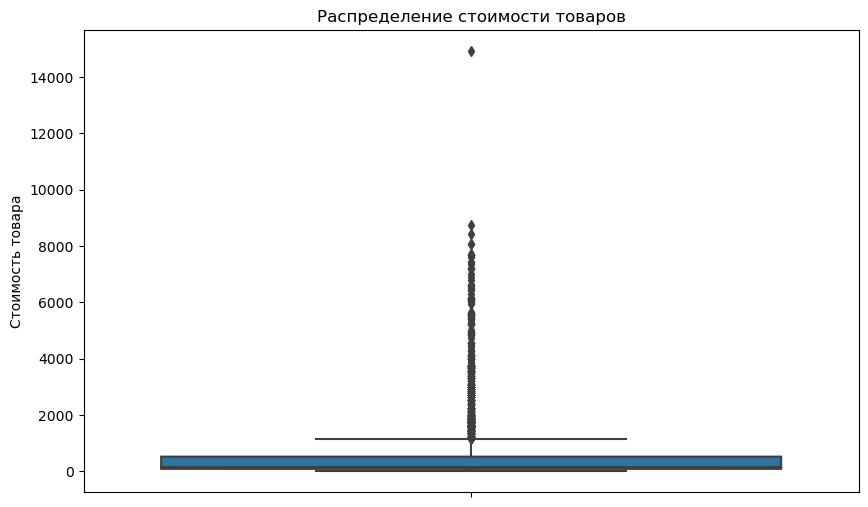

In [129]:
plt.figure(figsize=(10, 6))
sns.boxplot(y=orders['price'], notch=True)
plt.ylabel('Стоимость товара')
plt.title('Распределение стоимости товаров');

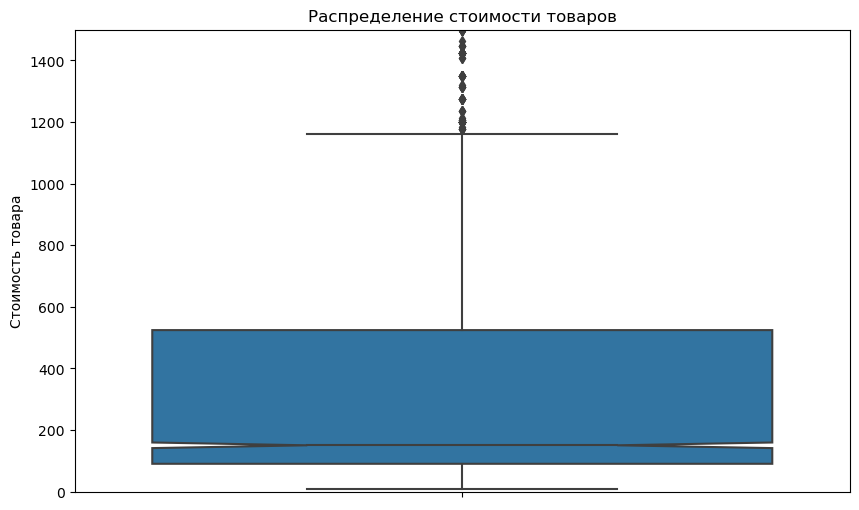

In [130]:
plt.figure(figsize=(10, 6))
sns.boxplot(y=orders['price'], notch=True)
plt.ylim(0,1500)
plt.ylabel('Стоимость товара')
plt.title('Распределение стоимости товаров');

В среднем стоимость заказываемых товаров около 150 рублей за единицу. 
Видим, что в основном, люди заказывают товары не дороже 2000 рублей, однако, есть товары и более дорогого сегмента. Есть и товары стоимостью выше 14 000 рублей.
Посмотрим как заказывали товары в зависимости от стоимости.

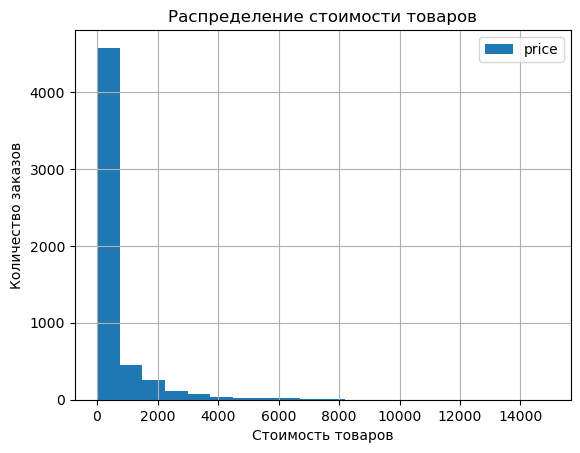

In [132]:
orders.plot(y='price', kind='hist', bins=20, grid=True)
plt.xlabel('Стоимость товаров')
plt.ylabel('Количество заказов')
plt.title('Распределение стоимости товаров');

Больше всего заказывали товары стоимостью до 1000 рублей.

Посмотрим как распределялись заказы дорогих товаров.

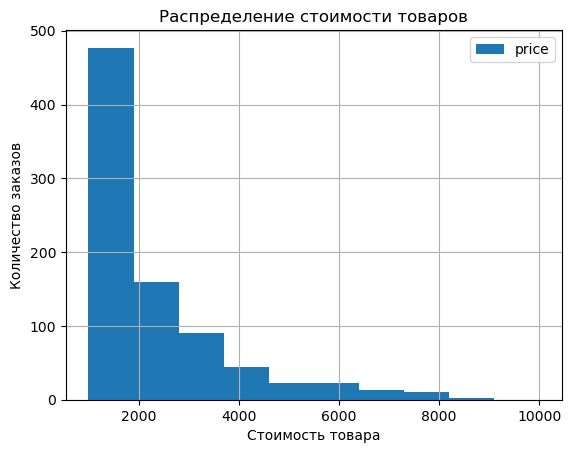

In [134]:
orders.plot(y='price', kind='hist', bins=10,range=(1000,10000), grid=True)
plt.xlabel('Стоимость товара')
plt.ylabel('Количество заказов')
plt.title('Распределение стоимости товаров');

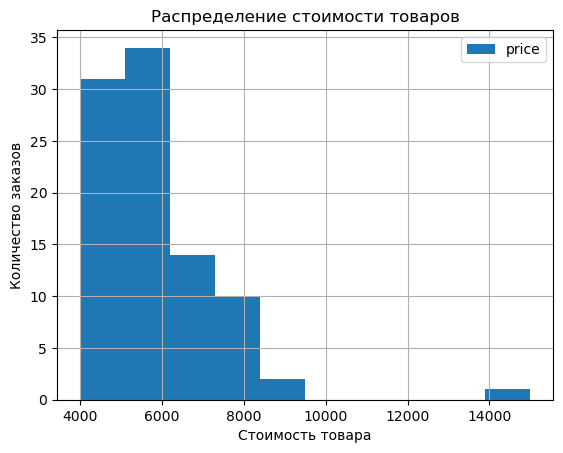

In [135]:
orders.plot(y='price', kind='hist', bins=10,range=(4000,15000), grid=True)
plt.xlabel('Стоимость товара')
plt.ylabel('Количество заказов')
plt.title('Распределение стоимости товаров');

Видим, что товары стоимость которых от 2000 до 4000 рублей заказываются довольно активно, а вот стоимостью выше 6000 - уже единичные заказы, особенно выше 7000 рублей.

In [137]:
orders[orders['price']>=7000][['product','price','quantity']]

,product,price,quantity
654,Сумка-тележка хозяйственная Rolser MOU041 malv...,7597.0,1
1241,Гладильная доска Leifheit AirBoard Compact M P...,7424.0,1
1981,Сумка-тележка хозяйственная Andersen Alu Star ...,8437.0,1
2339,Сумка-тележка хозяйственная Rolser IMX006 bass...,7679.0,1
2697,Сумка-тележка хозяйственная Andersen Royal Sho...,8737.0,1
2976,Автоматическая щетка Leifheit для мытья окон с...,7229.0,1
2997,Сумка-тележка хозяйственная Rolser MNB019 rojo...,8077.0,1
5087,Сушилка для белья Leifheit Pegasus 200 DeLuxe ...,7004.0,1
5992,Сушилка уличная Leifheit 85210 LINOMATIC V 400...,14917.0,1
5994,Сумка-тележка хозяйственная Rolser MNB017 fucs...,7679.0,1


Самыми дорогими являются сумки-тележки и уличная сушилка, их заказывают очень редко.


Посмотрим теперь на самые дешевые товары.

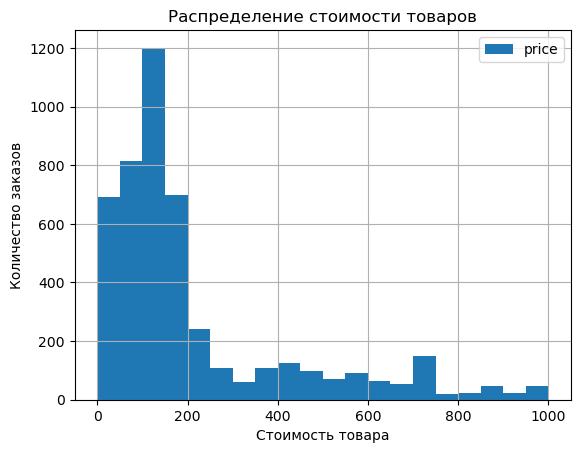

In [140]:
orders.plot(y='price', kind='hist', bins=20,range=(0,1000), grid=True)
plt.xlabel('Стоимость товара')
plt.ylabel('Количество заказов')
plt.title('Распределение стоимости товаров');

Больше всего заказывали товары до 200 рублей за единицу.

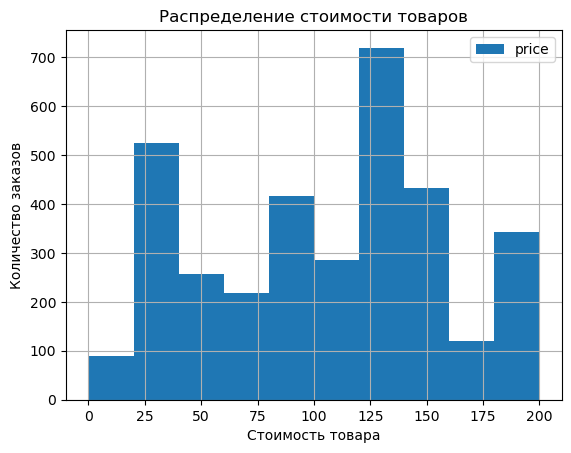

In [142]:
orders.plot(y='price', kind='hist', bins=10,range=(0,200), grid=True)
plt.xlabel('Стоимость товара')
plt.ylabel('Количество заказов')
plt.title('Распределение стоимости товаров');

Посмотрим на товары, стоимостью до 20 рублей за единицу.

In [144]:
orders[orders['price']<=20][['product','price','quantity']]

,product,price,quantity
160,"Стяжка оконная с болтом СТ-55 цинк, 1108354",19.0,64
170,"Стяжка оконная с болтом СТ-55 цинк, 1108354",20.0,10
211,"Крепеж для пружины дверной, 1107055",19.0,150
277,Муляж Красное яблоко мини полиуретан d-6 см,19.0,30
576,Муляж Красное яблоко мини полиуретан d-6 см,20.0,15
...,...,...,...
7385,Искусственный цветок Тюльпан пластиковый откры...,20.0,1
7437,"Укроп Обильнолистный 3,0 г 4660010772562",10.0,1
7450,Настурция Орхидное пламя 5 шт 4650091480692,14.0,1
7454,Настурция Орхидное пламя 5 шт 4650091480692,14.0,1


Видим, что в основном, это семена и их заказывают редко и по одному товару.

Посмотрим другим способом на распределение стоимости заказанных товаров

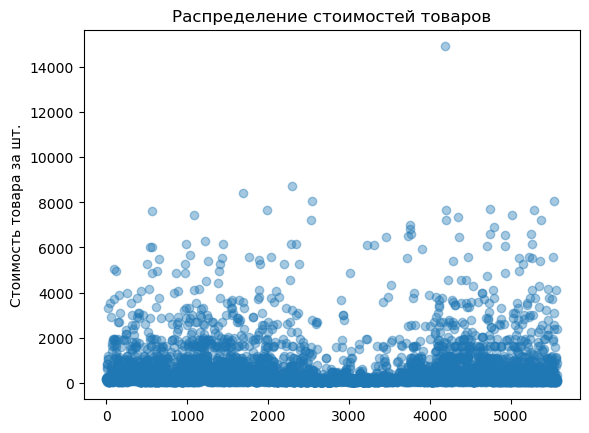

In [147]:
# задаем количество точек на графике
x_values = pd.Series(range(0,len(orders)))
plt.scatter(x_values, orders['price'], alpha=0.4)
plt.title('Распределение стоимостей товаров')
plt.ylabel('Стоимость товара за шт.'); 

Посчитаем 95-й и 99-й перцентиль, чтобы узнать какой процент заказанных товаров идут по высокой стоимости

In [149]:
print(np.percentile(orders['price'], [95, 99])) 

[2399. 5249.]


Итак, не более 1%  записей заказанных товаров идут со стоимостью выше 5250 рублей за единицу товара. 

Полсмотрим как распределялось количество заказанных товаров

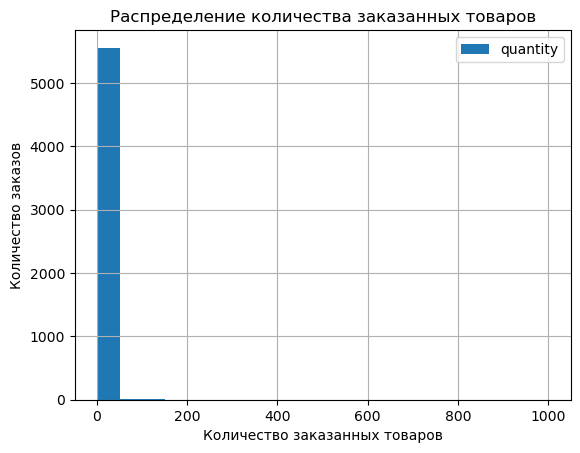

In [152]:
orders.plot(y='quantity', kind='hist', bins=20, grid=True)
plt.xlabel('Количество заказанных товаров')
plt.ylabel('Количество заказов')
plt.title('Распределение количества заказанных товаров');

Как видим, в основном заказывали не больше 10 товаров одного вида.

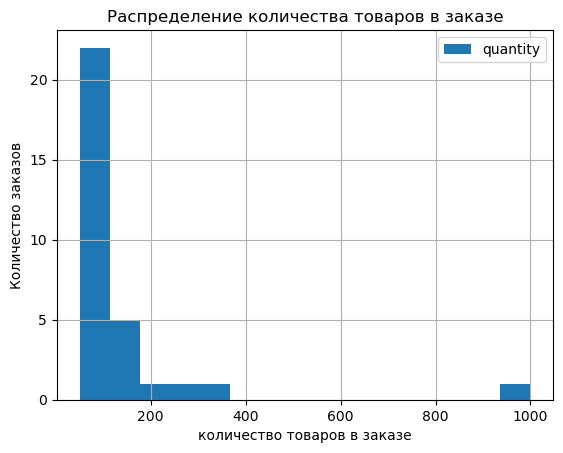

In [154]:
orders.plot(y='quantity', kind='hist', bins=15, range=(50,1000), grid=True)
plt.xlabel('количество товаров в заказе')
plt.ylabel('Количество заказов')
plt.title('Распределение количества товаров в заказе');

ОДнако, если посмотреть поближе, то видим, что есть заказы с 1000 заказанных одинаковых товаров.

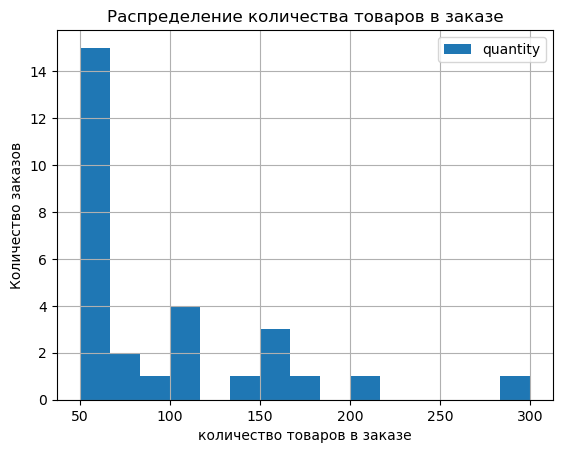

In [156]:
orders.plot(y='quantity', kind='hist', bins=15, range=(50,300), grid=True)
plt.xlabel('количество товаров в заказе')
plt.ylabel('Количество заказов')
plt.title('Распределение количества товаров в заказе');

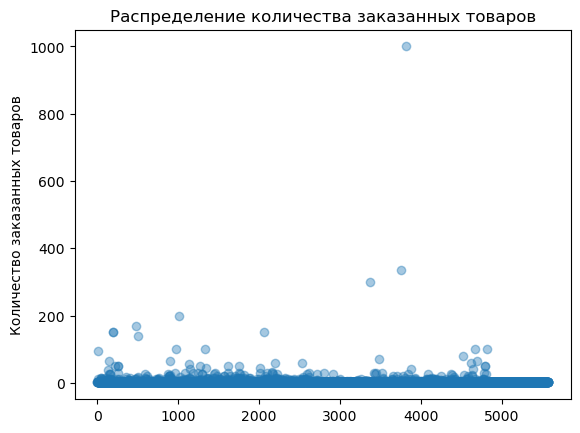

In [157]:
# задаем количество точек на графике
x_values = pd.Series(range(0,len(orders)))
plt.scatter(x_values, orders['quantity'], alpha=0.4)
plt.title('Распределение количества заказанных товаров')
plt.ylabel('Количество заказанных товаров'); 

Посчитаем перцентили для того, чтобы оценить какое количество записей содержат большое количество заказанных товаров.

In [159]:
print(np.percentile(orders['quantity'], [95, 99])) 

[ 6. 27.]


Не более 1% всех записей имеют больше 30 одинаковых заказанных товаров. Посмотрим на топ-10 по количенству заказанных товаров.

In [161]:
orders.nlargest(15,'quantity')

,date,customer_id,order_id,product,quantity,price,date_1,month,month_year
5456,2019-06-18 15:00:00,312e9a3e-5fca-43ff-a6a1-892d2b2d5ba6,71743,"Вантуз с деревянной ручкой d14 см красный, Bur...",1000,675.0,2019-06-18 15:00:00,6,2019-06
5071,2019-06-11 07:00:00,146cd9bf-a95c-4afb-915b-5f6684b17444,71668,Вешалки мягкие для деликатных вещей 3 шт шоколад,334,148.0,2019-06-11 07:00:00,6,2019-06
3961,2019-05-20 21:00:00,5d189e88-d4d6-4eac-ab43-fa65a3c4d106,71478,Муляж ЯБЛОКО 9 см красное,300,51.0,2019-05-20 21:00:00,5,2019-05
1158,2018-12-10 14:00:00,a984c5b7-ff7e-4647-b84e-ef0b85a2762d,69289,"Ручка-скоба РС-100 белая *Трибатрон*, 1108035",200,29.0,2018-12-10 14:00:00,12,2018-12
568,2018-11-01 08:00:00,aa42dc38-780f-4b50-9a65-83b6fa64e766,68815,Муляж ЯБЛОКО 9 см красное,170,51.0,2018-11-01 08:00:00,11,2018-11
211,2018-10-11 14:00:00,cd09ea73-d9ce-48c3-b4c5-018113735e80,68611,"Крепеж для пружины дверной, 1107055",150,19.0,2018-10-11 14:00:00,10,2018-10
212,2018-10-11 14:00:00,cd09ea73-d9ce-48c3-b4c5-018113735e80,68611,Пружина дверная 240 мм оцинкованная (Д-19 мм) ...,150,38.0,2018-10-11 14:00:00,10,2018-10
2431,2019-03-23 10:00:00,685d3d84-aebb-485b-8e59-344b3df8b3d3,70841,Плечики пластмассовые Размер 52 - 54 Тула 1205158,150,20.0,2019-03-23 10:00:00,3,2019-03
586,2018-11-02 11:00:00,0c5aaa88-e346-4f87-8f7a-ad8cbc04e965,68831,Муляж ЯБЛОКО 9 см красное,140,59.0,2018-11-02 11:00:00,11,2018-11
1103,2018-12-04 17:00:00,7d255526-fcc2-4f79-b28a-217d7d2373a8,69206,"Щетка для посуды *ОЛЯ*, Мультипласт 1807010",100,26.0,2018-12-04 17:00:00,12,2018-12


Как видим, есть оптовые покупатели, которые закупали некоторые товары в больших количествах, но таких пользователей немного. Хотя странно выглядит заказ в 1000 вантузов. Удалим эту строку.

In [163]:
orders = orders[orders['quantity']<1000]
orders = orders.reset_index(drop = True)
# orders.head()


In [164]:
orders.shape

(5576, 9)

В итоге, у нас осталось 5576 строк.

### Сумма заказа

Так как у нас в данных есть только цена  товара, то мы не видим, сколько каждый клиент заплатил за заказ. Добавим столбцы  стоимость товара `purchase`.

In [168]:
orders['purchase'] = orders['quantity'] * orders['price']

In [169]:
orders.sample(5)

,date,customer_id,order_id,product,quantity,price,date_1,month,month_year,purchase
195,2018-10-11 14:00:00,953ff76b-4177-491f-95a1-4f7256fd76ac,14486,Пеларгония зональная диам. 12 см ярко красная ...,1,188.0,2018-10-11 14:00:00,10,2018-10,188.0
3053,2019-05-12 19:00:00,3d5fef90-4a65-4a7e-84cf-010eba7b038d,14753,Дыня Алтайская d-7 см скороспелая,1,30.0,2019-05-12 19:00:00,5,2019-05,30.0
1906,2019-03-06 22:00:00,8bdca104-a6cb-4475-9552-1e773caa1782,70647,"Гладильная доска НИКА БЭЛЛЬ-ЮНИОР1 112х34,5 см...",1,637.0,2019-03-06 22:00:00,3,2019-03,637.0
352,2018-10-23 13:00:00,49b9c587-c19e-4481-bace-967aeac357fa,14494,Пеларгония зональная диам. 12 см малиново-крас...,1,188.0,2018-10-23 13:00:00,10,2018-10,188.0
1770,2019-03-01 08:00:00,c971fb21-d54c-4134-938f-16b62ee86d3b,70523,Подарочный набор на 8 Марта Пеларгония красная...,2,194.0,2019-03-01 08:00:00,3,2019-03,388.0


## Исследовательский анализ данных

### Формирование товарных категорий

Для дальнейшей работы нам необходимо разделить товары на категории, так как уникальных названий товаров очень много.

In [173]:
orders['product'].nunique()

2342

In [174]:
orders = orders.reset_index(drop=True)

Сначала переведем названия в нижний регистр и уберем лишние пробелы в начале и конце строк, чтобы избежать разницы в названии товаров.

In [176]:
for i in range(orders.shape[0]):
    orders.loc[i,'product'] = orders.loc[i,'product'].lower().strip(' ')
orders.tail()

,date,customer_id,order_id,product,quantity,price,date_1,month,month_year,purchase
5571,2020-01-30 21:00:00,63208953-a8e4-4f77-9b47-3a46e7b72eee,104002,томата (помидор) черниченский черри № 116 сорт...,2,38.0,2020-01-30 21:00:00,1,2020-01,76.0
5572,2020-01-30 22:00:00,d99d25f1-4017-4fcd-8d29-c580cc695a1a,107336,дендробиум санок анна грин 1 ствол d-12 см,1,869.0,2020-01-30 22:00:00,1,2020-01,869.0
5573,2020-01-31 02:00:00,2c9bd08d-8c55-4e7a-9bfb-8c56ba42c6d6,106336,подставка для обуви резиновая attribute 80x40 ...,1,354.0,2020-01-31 02:00:00,1,2020-01,354.0
5574,2020-01-31 12:00:00,cdd17932-623e-415f-a577-3b31312fd0e2,102002,тагетис крупноцветковый рассада однолетних цве...,1,128.0,2020-01-31 12:00:00,1,2020-01,128.0
5575,2020-01-31 15:00:00,2e460a26-35af-453d-a369-a036e95a40e0,103225,вешалка для блузок 41 см красный attribute ahm781,1,104.0,2020-01-31 15:00:00,1,2020-01,104.0


In [177]:
orders['product'].nunique()

2340

Сформируем следующие товарные категории:
* муляжи 

*в эту категорию войдут искусственные цветы, муляжи овощей и фруктов, композиции из искусственных цветов*

* растения

*сюда войдут комнатные растения, рассада и семена* 

* посуда

*все для приготовления и употребления пищи*

* товары для дома

*все, что может потребоваться дома

* текстиль

*от теплого одеяла до уютного халата и красивых полотенец и скатерти на кухню*

* хранение вещей

*всевозможные кофры, ящики, чехлы, вешалки, короба и т.д.

* инструменты

*сверла, стяжки, пружины, напильники, шнуры и шпагаты и многое другое

Создадим словарь, содержащий ключевые слова, по которым мы можем отнести товар в одну из категорий.

In [180]:
categories = {
    'муляж':['муляж', 'искусствен','искуствен'],
    
    'растения':['рассада', 'кассет', 'тыква', 'томат', 'кабачок', 'патиссон', 'черенок', 'пряные травы', 'осина', 'клубник',
              'дыня', 'd-', 'диам', 'растение', 'объем','горшк', 'калла', 'тюльпан', 'дендробиум', 'укроп', 'тимьян', 
              'незабудка', 'арбуз', 'виноград', 'цинния', 'кипарис', 'петуния', 'вербей', 'цикламен', 'георгин', 'бегония',
               'земляника', 'горох', 'базилик', 'упаковк','комнатн', 'эшшольция', 'пеларгония', 'космея', 'кашпо', 'настурция',
               'морковь', 'бархатцы', 'календула', 'салат', 'капуста', 'гвоздика', 'петрушка', 'флокс', 'огурец', 'годеция',
               'кореопсис', 'лапчатка', 'цинерария', 'смолевка', 'маттиола', 'лаватера'],
    
    'посуда': ['сковород', 'чайник эмалированный', 'противен', 'крышка', 'лоток', 'емкост', 'котел', 'вилка','нож',
               'ложка столовая', 'ложка чайная', 'столов', 'толкушк', 'рыбочистк', 'терк', 'тарелка','салатн', 
            'бульон', 'масленк','овощечистк','фужер', 'чайн', 'круж','стакан', 'бокал', 'банк', 'кастрюл', 'половник', 'яйц',
              'соковыжималк', 'бидон', 'сахарниц', 'миск', 'термос', 'кондитерск', 'пикник', 'хлебниц', 'сотейник', 'выпечк',
              'посуд', 'кухонн', 'свч', 'блюдо', 'сито', 'венчик', 'скалка', 'орехоколка', 'настольн', 'просеиватель','соус',
            'разделочн', 'блюдц', 'электроштопор','кувшин', 'продукт', 'кекс','пресс для чеснока', 'яиц','лопатка', 'торт',
              'контейнер герметичный'],
    
    'товары для дома': ['сушилк','крючок','корзин','щетк','прищеп','коврик', 'корзин', 'мусор', 'ковер', 'вкладыш', 'карниз',
                      'веник', 'швабр', 'корыт', 'урн', 'сметк', 'пластмасс', 'тележк', 'стиральн','чистящ', 'средство', 
                      'перчат', 'гладильн', 'подрукавник', 'глаж', 'досок', 'подкладк', 'ванн', 'зубн', 'ерш', 
                      'противоскольз', 'унитаз','мыл', 'подголовник', 'ёрш', 'миксер', 'светильник', 'утюг', 'пробк', 'ткан',
                      'чайник электрический', 'кипятильник', 'совок', 'тряпк', 'решетк', 'пьезозажигалк', 'варк','отбеливател',
                      'мешок', 'отделитель', 'лоток', 'моп', 'ваза', 'пуф', 'вантуз', 'окномойка', 'ведро', 
                      'антинакипин', 'отжим', 'скребок', 'окон', 'насадк', 'бак', 'сетк', 'пылесос', 'стирк', 'защитн', 
                      'ключниц', 'ковёр', 'бензин', 'ложка обувная', 'сменный блок', 'антижир', 'губка', 'термометр', 'фото',
                       'кондиционер', 'ель', 'кольц', 'напольн', 'рассекатель', 'посудомоечн', 'маск', 'колес', 'фиксатор',
                       'таз','багажн', 'фен', 'гои'],
    
    'текстиль' : ['плед', 'скатерт', 'простын', 'подушк', 'полотен', 'салфет', 'наматр', 'халат', 'одеяло', 'покрывало', 
                  'пододеяльник', 'наволочка'],
    
    'хранение вещей' : ['кофр', 'одежд', 'плать','хранен', 'вешал', 'плечик', 'короб', 'полк', 'ящик','стеллаж','вакуумный',
                       'этажерк', 'обувниц', 'комод', 'подставк', 'костюм'],
    
    'инструменты' : ['свер', 'стяжк', 'пружин', 'петл', 'сварк', 'стремянк','шпингалет', 'угольник', 'линейк', 'крепеж', 
                     'уголок', 'ручк', 'завертк', 'инструмент', 'веревк', 'шпагат', 'шнур', 'напильник', 'штангенциркуль',
                     'фал'],
    
}

### Категоризация товаров

Создадим функцию, которая по названию товара будет присваивать ему одну из установленных категорий

In [183]:
def get_category(product, categories):
    '''
    Функция сравнивает ключевые слова каждой категории с названием товара и возвращает название  подходящей категории.
    Если все ключевые слова не подходят, то функция возвращает "неизвестная категория".
    
    '''
    for category, keywords in categories.items():
        for keyword in keywords:
            if keyword in product:
                return category
    return 'неизвестная категория'
        


Проверим, как работает функция на некоторых названиях товаров

In [185]:
print(get_category('хризолидокарпус лутесценс d-9 см', categories))   
print(get_category('томата (помидор) черниченский черри № 116 сорт', categories))
print(get_category('вешалка для блузок 41 см красный attribute ahm781', categories))
print(get_category('тележка багажная delta тбр-20 коричневый с оранжевым грузоподъемность 25 кг сумка и 50 кг каркас россия', categories))

растения
растения
хранение вещей
товары для дома


Создадим еще один столбец с названием категории товаров.

In [187]:
orders['category'] = orders['product'].apply(lambda x: get_category(x, categories))
orders.sample(5)

,date,customer_id,order_id,product,quantity,price,date_1,month,month_year,purchase,category
5573,2020-01-31 02:00:00,2c9bd08d-8c55-4e7a-9bfb-8c56ba42c6d6,106336,подставка для обуви резиновая attribute 80x40 ...,1,354.0,2020-01-31 02:00:00,1,2020-01,354.0,хранение вещей
1106,2018-12-19 14:00:00,c971fb21-d54c-4134-938f-16b62ee86d3b,69463,новогоднее дерево ель сербская d-27 см h-200 см,1,3524.0,2018-12-19 14:00:00,12,2018-12,3524.0,растения
1526,2019-02-11 11:00:00,337889bb-2ba7-4173-b4f1-4e7c2cb55fd1,70205,"кастрюля чугунная 24 см, красная, 3.6 л, pyrex...",1,1799.0,2019-02-11 11:00:00,2,2019-02,1799.0,посуда
1067,2018-12-16 17:00:00,0c903c67-9ebf-4401-a293-78e10245164f,69389,чехол для одежды малый 100х60х10 см светло-беж...,2,367.0,2018-12-16 17:00:00,12,2018-12,734.0,хранение вещей
3460,2019-05-27 17:00:00,3a432f23-1135-4f8a-9351-da4987f1c4cf,71529,вешалка напольная atlant бук темная 154-179х90...,1,1499.0,2019-05-27 17:00:00,5,2019-05,1499.0,товары для дома


Проверим, что все товары распределились по категориям и у нас нет "неизвестной категории".

In [189]:
orders['category'].value_counts()

category
растения           2858
товары для дома    1690
посуда              399
муляж               320
хранение вещей      159
текстиль             78
инструменты          72
Name: count, dtype: int64

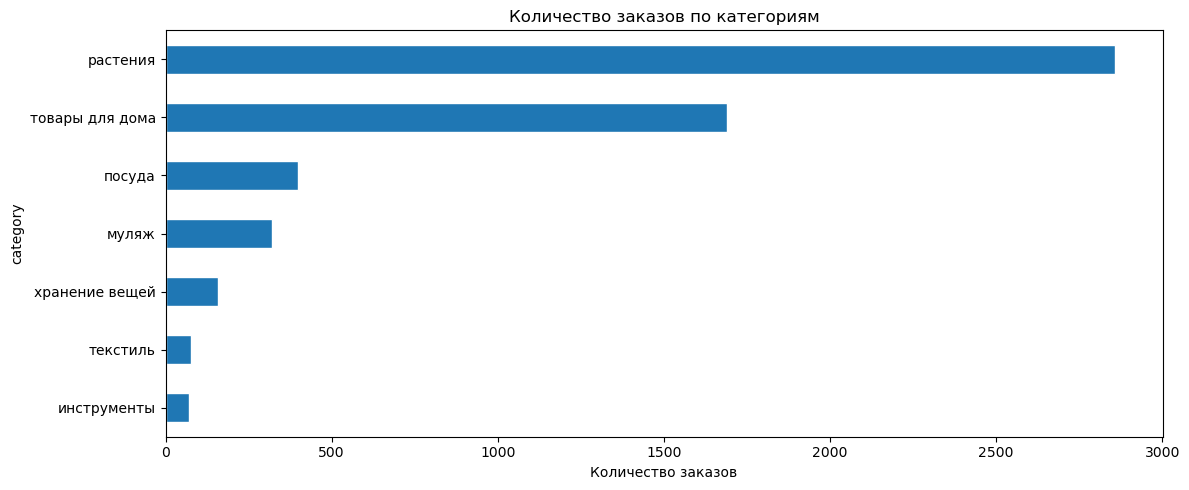

In [190]:
orders['category'].value_counts(ascending=True).plot(kind='barh',figsize=(12,5), ec='white')
plt.title('Количество заказов по категориям')
plt.xlabel('Количество заказов')
plt.tight_layout()
plt.show();

In [191]:
orders[orders['category']=='неизвестная категория']

,date,customer_id,order_id,product,quantity,price,date_1,month,month_year,purchase,category


Как видим, категоризация прошла успешно. Также можем сказать, что чаще всего в заказ попадали растения.

### Популярные категории по покупателям 

(группируем по `customer_id`)

Найдем категории товаров, популярные у каждого пользователя

In [195]:
temp = (orders.pivot_table(index=['customer_id', 'category'], values='quantity', aggfunc={'count', 'sum'}).
        sort_values(by='count', ascending=False)
       )
temp[temp['count']>5]

,,count,sum
customer_id,category,,
c971fb21-d54c-4134-938f-16b62ee86d3b,товары для дома,87,186
d3b9ffea-d143-4747-8d59-74ab843d1ad6,растения,51,51
760aa067-90c3-4794-b7a9-a8831197388b,растения,36,37
c971fb21-d54c-4134-938f-16b62ee86d3b,растения,33,61
2a0acc09-e343-4f92-b5c0-f598ef2b07d4,растения,31,60
...,...,...,...
82eb3913-2c17-4935-8d1a-bbb10ac2bb48,растения,6,21
bfa5c5ea-61c5-4cd8-b257-329981a70ea0,растения,6,28
8851c688-9846-4ec3-a3cc-6b07754c45bb,растения,6,6


Как видим, в основном предпочтения у людей сходятся, они предпочитают заказывать в магазине растения.

###  Самые покупаемые товары 

(группируем по `product`, считаем сколько раз заказали и в каком количестве)

Найдем товары, которые чаще всего заказывали и в большом количестве. 

In [199]:
orders.pivot_table(index='product', values='quantity', aggfunc={'count','sum'}).sort_values(by=['count','sum'], ascending=False).head(20)

,count,sum
product,,
пеларгония розебудная red pandora укорененный черенок,66,82
пеларгония розебудная prins nikolai укорененный черенок,56,63
пеларгония зональная диам. 12 см сиреневый полумахровый,53,64
сумка-тележка 2-х колесная gimi argo синяя,47,47
пеларгония розебудная mary укорененный черенок,40,48
пеларгония розебудная margaretha укорененный черенок,31,47
пеларгония розебудная queen ingrid укорененный черенок,31,39
пеларгония зональная махровая лососевая,25,39
пеларгония зональная ринго вайт d-7 см h-10 см укорененный черенок,25,28


Как видим, чаще всего заказывали  живые цветы для высадки в землю и сумки-тележки.

### Самые продаваемые товары (категории) 

Найдем  как товарные категории заказывались и в каком количестве

In [203]:
orders.pivot_table(index='category', values='quantity', aggfunc='sum').sort_values(by='quantity', ascending=False)

,quantity
category,
растения,4276
товары для дома,3502
муляж,2440
посуда,1406
хранение вещей,878
инструменты,651
текстиль,282


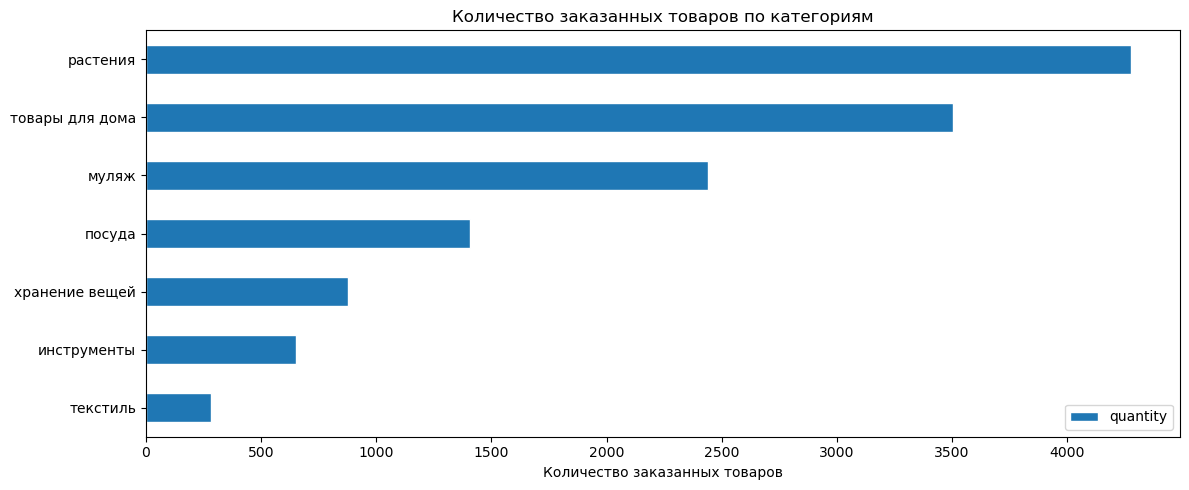

In [204]:
orders.pivot_table(index='category', values='quantity', aggfunc='sum').sort_values(by='quantity', ascending=True).plot(kind='barh',figsize=(12,5), ec='white')
plt.title('Количество заказанных товаров по категориям')
plt.ylabel('')
plt.xlabel('Количество заказанных товаров')
plt.tight_layout()
plt.show();

C:\ProgramData\anaconda3\Lib\site-packages\pandas\plotting\_matplotlib\core.py:885: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string ".-" (-> marker='.'). The keyword argument will take precedence.
  return ax.plot(*args, **kwds)
C:\ProgramData\anaconda3\Lib\site-packages\pandas\plotting\_matplotlib\core.py:885: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string ".-" (-> marker='.'). The keyword argument will take precedence.
  return ax.plot(*args, **kwds)
C:\ProgramData\anaconda3\Lib\site-packages\pandas\plotting\_matplotlib\core.py:885: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string ".-" (-> marker='.'). The keyword argument will take precedence.
  return ax.plot(*args, **kwds)
C:\ProgramData\anaconda3\Lib\site-packages\pandas\plotting\_matplotlib\core.py:885: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt 

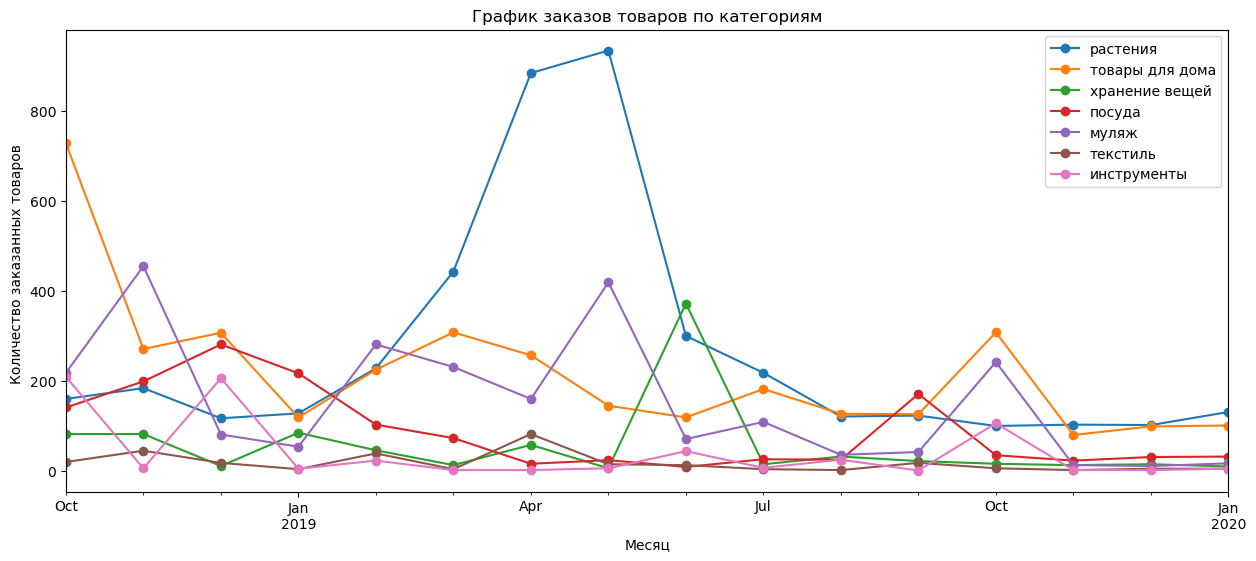

In [205]:
plt.figure(figsize=[15, 6]);
category_list = orders['category'].unique()
#plt.style.use('bmh') 
for i in category_list:
    lines = (orders[orders['category']==i].groupby('month_year')['quantity'].sum().
             plot(x='month_year',y='quantity',kind='line',style='.-',marker='o', label=i))
    
    #plt.xticks(np.arange(min(orders['month_year']), max(orders['month_year'])+1, 1))
    plt.title('График заказов товаров по категориям')
    plt.ylabel('Количество заказанных товаров ')
    plt.xlabel('Месяц')
    plt.legend(loc='best');

Мы видим, что больше всего покупатели заказывали растения, товары для дома и муляжи (их заказали большее количество товаров).

При этом товары для дома наиболее активно заказывали в октябре, декабре и марте, растения с марта по май. В декабре активно покупали все, кроме муляжей, текстиля, товаров для хранения вещей и растений, что объяснимо покупкой подарков к праздникам. 

C:\ProgramData\anaconda3\Lib\site-packages\pandas\plotting\_matplotlib\core.py:885: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string ".-" (-> marker='.'). The keyword argument will take precedence.
  return ax.plot(*args, **kwds)
C:\ProgramData\anaconda3\Lib\site-packages\pandas\plotting\_matplotlib\core.py:885: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string ".-" (-> marker='.'). The keyword argument will take precedence.
  return ax.plot(*args, **kwds)
C:\ProgramData\anaconda3\Lib\site-packages\pandas\plotting\_matplotlib\core.py:885: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string ".-" (-> marker='.'). The keyword argument will take precedence.
  return ax.plot(*args, **kwds)
C:\ProgramData\anaconda3\Lib\site-packages\pandas\plotting\_matplotlib\core.py:885: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt 

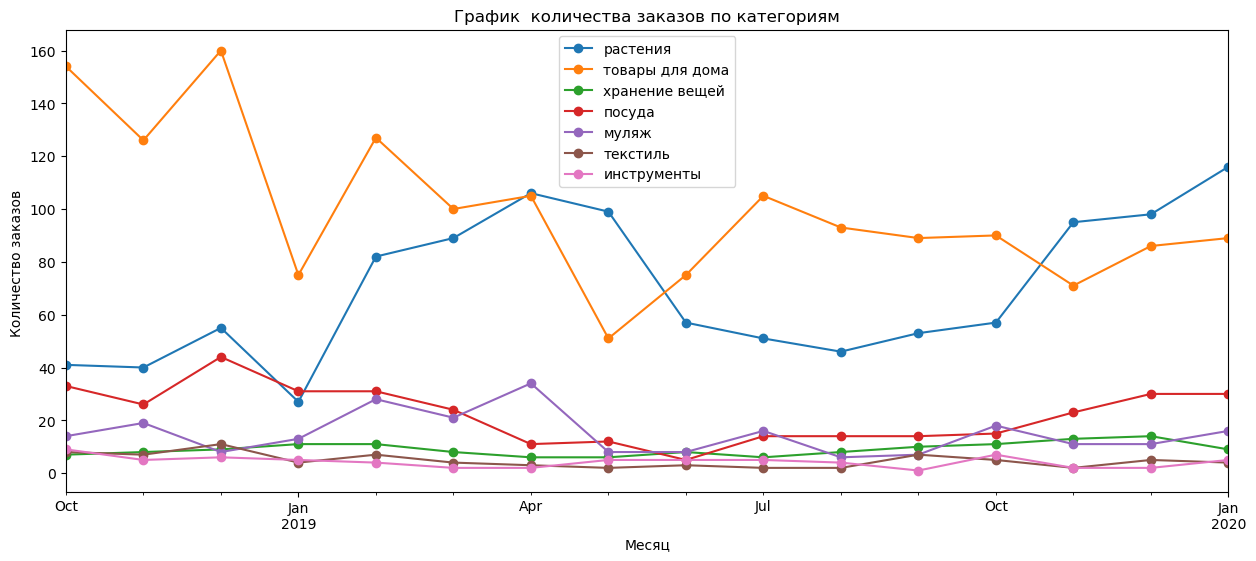

In [207]:
plt.figure(figsize=[15, 6]);
category_list = orders['category'].unique()
#plt.style.use('bmh') 
for i in category_list:
    lines = (orders[orders['category']==i].groupby('month_year')['order_id'].nunique().
             plot(x='month_year',y='quantity',kind='line',style='.-',marker='o', label=i))
    
    
    plt.title('График  количества заказов по категориям')
    plt.ylabel('Количество заказов ')
    plt.xlabel('Месяц')
    plt.legend(loc='best');

Если смотреть по количеству заказов, то видим, что весной и в ноябре-январе возрастает количество заказов растений, что в совокупности с изменением заказанного количества товара говорит нам о том, что осенью пик растений связан с увеличением количества заказов, а вот весной срабатывает совокупность факторов, становится больше заказов и больше товаров в одном заказе.

### Средний чек по покупателям

Найдем для каждого покупателя средний чек за заказ.

Для начала найдем сумму каждого заказа и количество заказанных товаров в нем.

In [212]:
customers = orders.pivot_table(index=['customer_id','order_id'],values=['purchase', 'quantity'],aggfunc='sum')
customers = customers.reset_index()
customers.columns = ['customer_id', 'order_id', 'revenue','n_products']
customers.head()

,customer_id,order_id,revenue,n_products
0,000d6849-084e-4d9f-ac03-37174eaf60c4,14943,555.0,4
1,001cee7f-0b29-4716-b202-0042213ab038,70290,442.0,1
2,00299f34-5385-4d13-9aea-c80b81658e1b,72965,914.0,2
3,002d4d3a-4a59-406b-86ec-c3314357e498,69990,1649.0,1
4,003bbd39-0000-41ff-b7f9-2ddaec152037,72796,2324.0,2


Теперь, посчитаем среднее количество товаров в заказе по пользователю и средний чек. 

In [214]:
bill = customers.pivot_table(index='customer_id', values=['revenue', 'n_products'],aggfunc='mean')
bill = bill.reset_index()
bill.columns =['customer_id','products_avg', 'bill_avg']
bill.head()

,customer_id,products_avg,bill_avg
0,000d6849-084e-4d9f-ac03-37174eaf60c4,4.0,555.0
1,001cee7f-0b29-4716-b202-0042213ab038,1.0,442.0
2,00299f34-5385-4d13-9aea-c80b81658e1b,2.0,914.0
3,002d4d3a-4a59-406b-86ec-c3314357e498,1.0,1649.0
4,003bbd39-0000-41ff-b7f9-2ddaec152037,2.0,2324.0


Выясним, какой средний чек у заказа, есть ли слишком дорогие заказы.

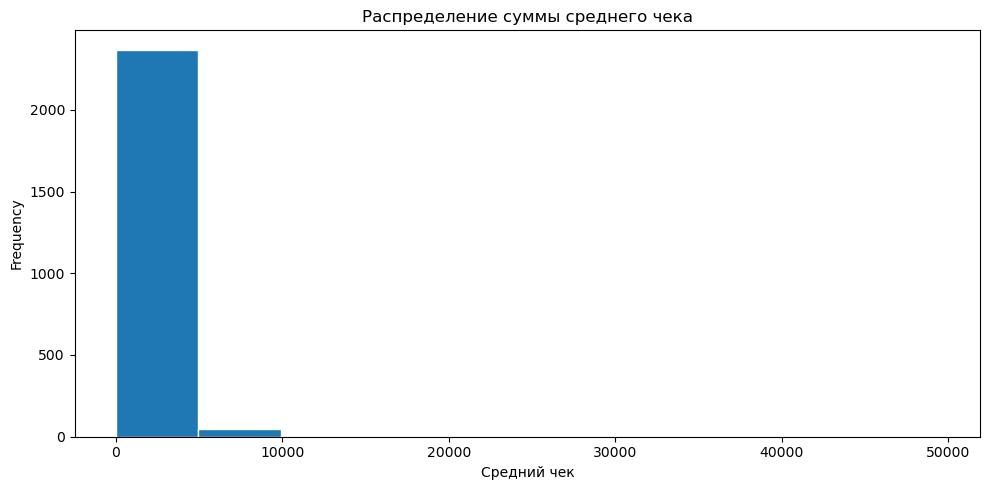

In [216]:
bill['bill_avg'].plot(kind='hist',bins=10,figsize=(10,5), ec='white')
plt.title('Распределение суммы среднего чека')
plt.xlabel('Средний чек')
plt.tight_layout()
plt.show();

Мы видим, что в среднем люди заказывают на сумму не более 5000 рублей за раз, но есть и заказы с суммой около 50000 рублей.

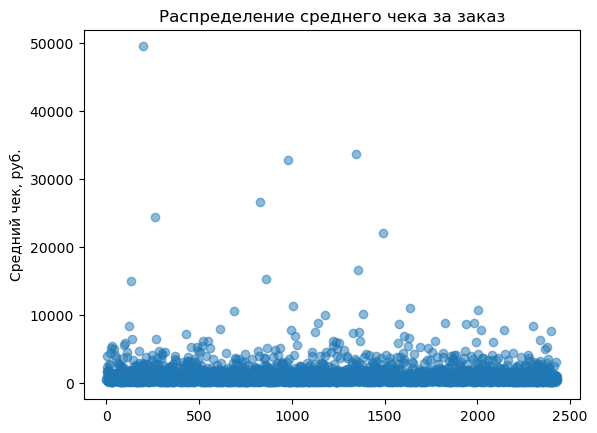

In [218]:
# задаем количество точек на графике
x_values = pd.Series(range(0,len(bill)));
plt.scatter(x_values, bill['bill_avg'], alpha=0.5)
plt.title('Распределение среднего чека за заказ')
plt.ylabel('Средний чек, руб.'); 

Посмотрим какой процент людей делают очень дорогие заказы.

In [220]:
print(np.percentile(bill['bill_avg'], [95, 99])) 

[3730.  7709.1]


Мы видим, что не более 1% пользователей заказывают в среднем более, чем не 7800 рублей. Из них только 6 имеют средний чек более 20000 рублей,такими заказами мы можем пренебречь.

In [222]:
bill[bill['bill_avg']>10000]

,customer_id,products_avg,bill_avg
133,0d87f4ae-465a-4fac-81e6-5d629761783e,1.00,14917.0
197,146cd9bf-a95c-4afb-915b-5f6684b17444,334.00,49432.0
265,1b2764ad-9151-4051-a46a-9b01b62e6335,5.00,24370.0
690,498f12a4-6a62-4725-8516-cf5dc9ab8a3a,21.25,10475.0
828,58a4c3cc-504f-43ea-a74a-bae19e665552,15.00,26616.0
863,5d189e88-d4d6-4eac-ab43-fa65a3c4d106,300.00,15300.0
982,6987e6d6-a63a-4ce2-a2d0-f424092d235e,57.00,32718.0
1004,6be74251-7159-4cc0-99fb-d034a17c61b0,45.00,11250.0
1348,8fba3604-ef57-4b9f-b2fe-3402fa8825c8,101.00,33680.0
1355,909564b8-3a5c-4d3e-8310-5ba1c837bbd7,3.00,16536.0


In [223]:
bill = bill[bill['bill_avg']<= 20000]

In [224]:
bill.shape

(2425, 3)

В итоге у нас есть данные о 2425 пользователях и их заказах, сумме среднего чека за заказ и среднем количестве заказанных товаров в одном заказе.

### Частота покупок

Найдем как часто делались заказы клиентами.

In [227]:
count_orders = (customers
                .pivot_table(index='customer_id', values='order_id', aggfunc='count')
                .sort_values(by='order_id', ascending=False)
               )
count_orders = count_orders.reset_index()
count_orders.columns = ['customer_id', 'order_count']
count_orders.head(10)

,customer_id,order_count
0,c971fb21-d54c-4134-938f-16b62ee86d3b,126
1,4d93d3f6-8b24-403b-a74b-f5173e40d7db,35
2,73d1cd35-5e5f-4629-8cf2-3fda829d4e58,17
3,b7b865ab-0735-407f-8d0c-31f74d2806cc,7
4,0184f535-b60a-4914-a982-231e3f615206,5
5,498f12a4-6a62-4725-8516-cf5dc9ab8a3a,4
6,e0535076-6270-4df2-8621-cb06264a94fa,4
7,bea7a833-2074-42db-bc49-4457abd3c930,4
8,552e17df-ba16-4e66-84fb-55a5557a6bea,3
9,e8204583-4d55-4724-ad3f-049c7db43bdd,3


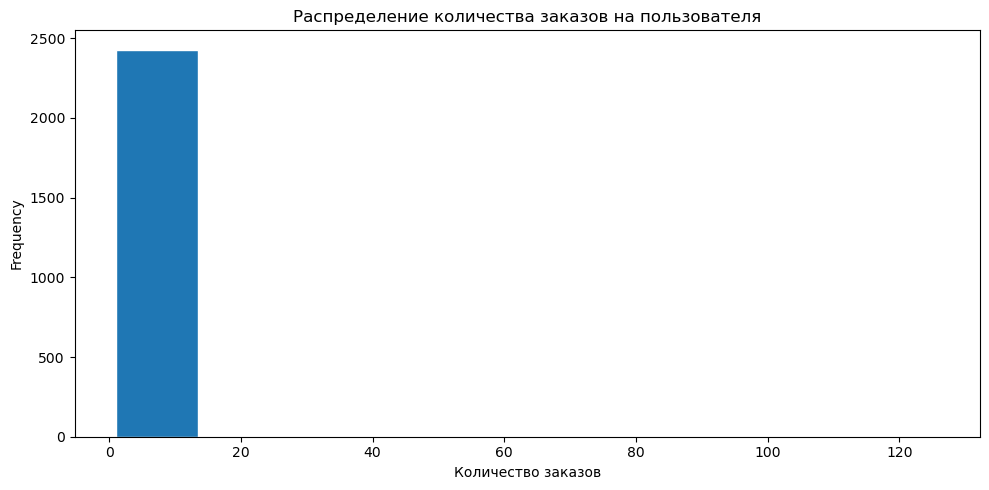

In [228]:
count_orders['order_count'].plot(kind='hist',bins=10,figsize=(10,5), ec='white')
plt.title('Распределение количества заказов на пользователя')
plt.xlabel('Количество заказов')
plt.tight_layout()
plt.show();

Мы видим, что в основном люди делали только один-два заказа, больше уже редко, есть единичные случаи, когда пользователь делал более 4 заказов. Есть уникальный покупатель, который сделал 126 заказов.
Посмотрим, какой процент пользователей делали много заказов.

In [230]:
print(np.percentile(count_orders['order_count'], [95, 99])) 

[2. 3.]


Не больше 1% заказывало больше трех раз. И из них 7 пользователей сделало от 4 до 35 заказов.Отбросим данные по покупателю с очень большим числом заказов.

In [232]:
count_orders = count_orders[count_orders['order_count']<20]

In [233]:
count_orders.shape

(2429, 2)

Таким образом, мы получили данные о 2429 пользователях, совершивших не более 20 заказов.

### Средняя стоимость товара

Посчитаем среднюю стоимость заказываемых пользователями товаров, чтобы в будущем мы могли ориентироваться в каком ценовом диапазоне каждый пользователь предпочитает товары.

In [237]:
prices = orders.pivot_table(index = 'customer_id', values = 'price', aggfunc='mean')

prices.head()

,price
customer_id,
000d6849-084e-4d9f-ac03-37174eaf60c4,138.75
001cee7f-0b29-4716-b202-0042213ab038,442.00
00299f34-5385-4d13-9aea-c80b81658e1b,457.00
002d4d3a-4a59-406b-86ec-c3314357e498,1649.00
003bbd39-0000-41ff-b7f9-2ddaec152037,1162.00


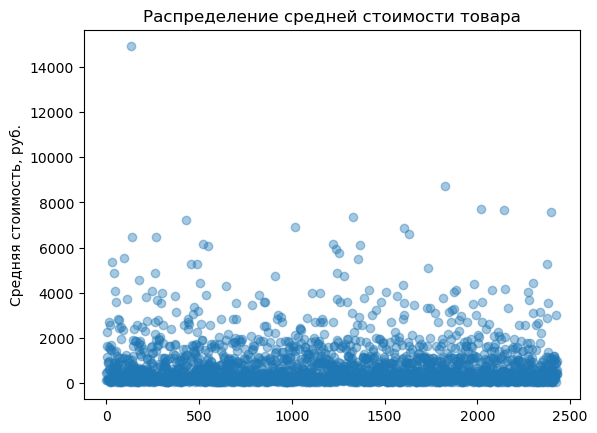

In [238]:
x_values = pd.Series(range(0,len(prices)));
plt.scatter(x_values, prices['price'], alpha=0.4)
plt.title('Распределение средней стоимости товара')
plt.ylabel('Средняя стоимость, руб.'); 

In [239]:
prices.shape

(2431, 1)

В основном, пользователи заказывают товары до 2000 рублей за единицу.

## Кластеризация пользователей

Для кластеризации пользователей мы воспользуемся методами машинного обучения. Для начала мы подготовим наши данные, собрав в одну таблицу столбцы с количеством заказов на пользователя, количеством товаров на заказ, средней стоимостью заказанных пользователем товаров и средним чеком за заказ, разобьем их на матрицу параметров и вектор целевой переменной - средний чек покупателя.


### Подготовка полученных данных

Соберем все полученные данные в одной таблице

In [245]:
clusters = bill.merge(count_orders, on='customer_id', how='inner').merge(prices, on='customer_id', how='inner')

In [246]:
clusters.head()

,customer_id,products_avg,bill_avg,order_count,price
0,000d6849-084e-4d9f-ac03-37174eaf60c4,4.0,555.0,1,138.75
1,001cee7f-0b29-4716-b202-0042213ab038,1.0,442.0,1,442.00
2,00299f34-5385-4d13-9aea-c80b81658e1b,2.0,914.0,1,457.00
3,002d4d3a-4a59-406b-86ec-c3314357e498,1.0,1649.0,1,1649.00
4,003bbd39-0000-41ff-b7f9-2ddaec152037,2.0,2324.0,1,1162.00


In [247]:
clusters.shape

(2423, 5)

In [248]:
clusters = clusters.reset_index(drop=True)
clusters.head()

,customer_id,products_avg,bill_avg,order_count,price
0,000d6849-084e-4d9f-ac03-37174eaf60c4,4.0,555.0,1,138.75
1,001cee7f-0b29-4716-b202-0042213ab038,1.0,442.0,1,442.00
2,00299f34-5385-4d13-9aea-c80b81658e1b,2.0,914.0,1,457.00
3,002d4d3a-4a59-406b-86ec-c3314357e498,1.0,1649.0,1,1649.00
4,003bbd39-0000-41ff-b7f9-2ddaec152037,2.0,2324.0,1,1162.00


Для разбиения на группы нам не нужны `customer_id`, удалим этот столбец.

In [250]:
df = clusters.drop('customer_id', axis=1)

Проверим как коррелируют наши найденные параметры и влияют ли они на целевую переменную - средний чек за заказ.

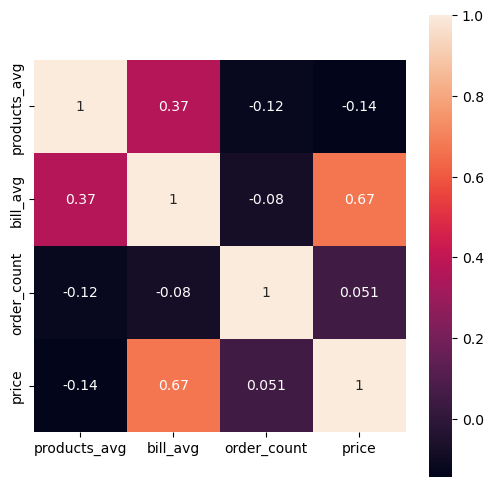

In [252]:
cm = df.corr()
fig, ax = plt.subplots(figsize=(6,6))
#нарисуем тепловую карту с подписями для матрицы корреляций
sns.heatmap(cm, annot=True, square = True) 

plt.show()


Получили, что параметры не коррелируют и нет линейной зависимости среднего чека ни от одного из найденных параметров.

### Построение дендрограммы

Построим дендрограмму, чтобы определить оптимальное количество классов, на которые мы будем делить наших пользователей.

In [256]:
# стандартизируем данные
sc = StandardScaler()
X_sc = sc.fit_transform(df)
linked = linkage(X_sc, method = 'ward') 

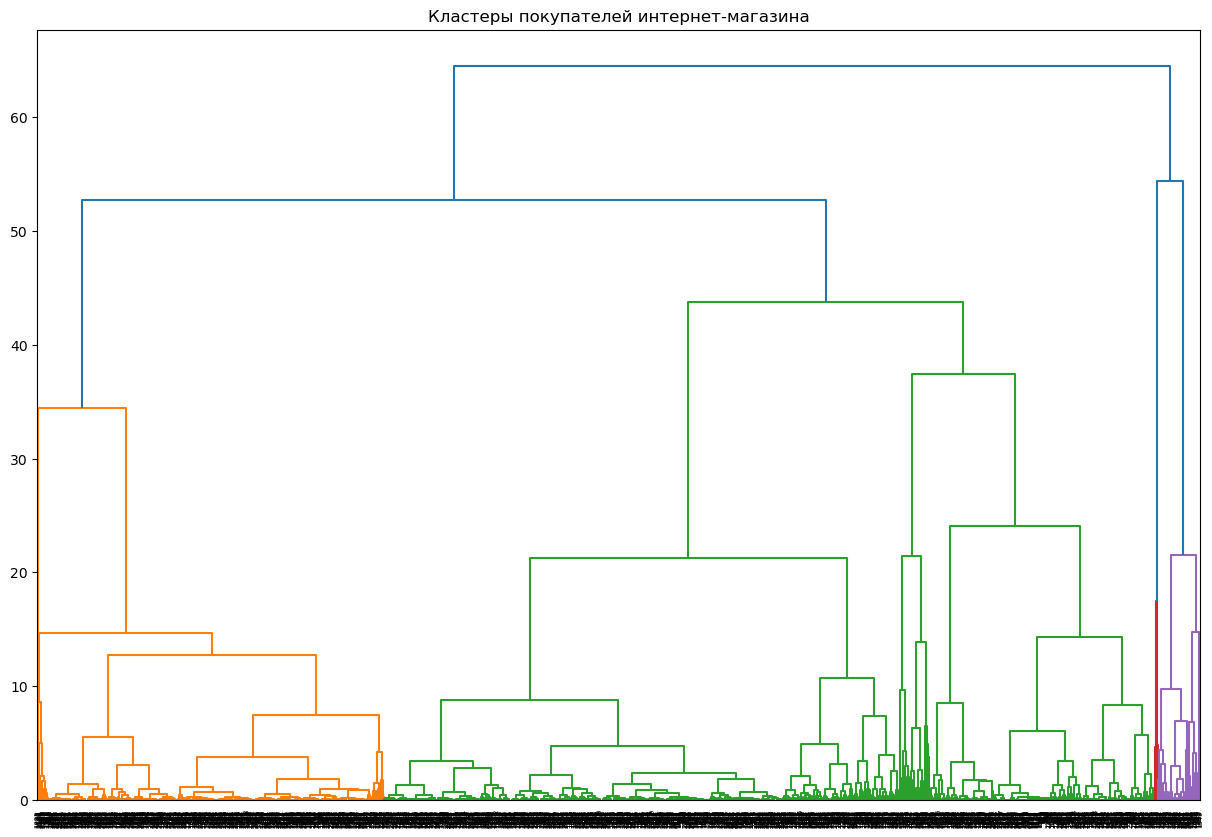

In [257]:
# построим дендрограмму
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Кластеры покупателей интернет-магазина')
plt.show() 

Итак, мы получили, что оптимально будет разбить наших пользователей на 4 класса.

### Разделение данных на группы

Будем использоdать метод K-means для разделения пользователей на группы.

In [261]:
# задаём модель k_means с числом кластеров 4 
km = KMeans(n_clusters=4, random_state=0)

In [262]:
# прогнозируем кластеры для наблюдений (алгоритм присваивает им номера от 0 до 3)
labels = km.fit_predict(X_sc)

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [263]:
# сохраняем метки кластера в поле нашего датасета
df['cluster_km'] = labels
df.head()

,products_avg,bill_avg,order_count,price,cluster_km
0,4.0,555.0,1,138.75,1
1,1.0,442.0,1,442.00,1
2,2.0,914.0,1,457.00,1
3,1.0,1649.0,1,1649.00,1
4,2.0,2324.0,1,1162.00,1


In [264]:
clusters['cluster'] = labels
clusters.head()

,customer_id,products_avg,bill_avg,order_count,price,cluster
0,000d6849-084e-4d9f-ac03-37174eaf60c4,4.0,555.0,1,138.75,1
1,001cee7f-0b29-4716-b202-0042213ab038,1.0,442.0,1,442.00,1
2,00299f34-5385-4d13-9aea-c80b81658e1b,2.0,914.0,1,457.00,1
3,002d4d3a-4a59-406b-86ec-c3314357e498,1.0,1649.0,1,1649.00,1
4,003bbd39-0000-41ff-b7f9-2ddaec152037,2.0,2324.0,1,1162.00,1


In [265]:
# посмотрим на средние значения наших признаков по кластеру
df.groupby('cluster_km').agg('mean')

,products_avg,bill_avg,order_count,price
cluster_km,,,,
0,2.696306,4293.923110,1.340206,3256.541237
1,4.961346,859.149964,1.000000,420.225036
2,1.579652,680.561234,2.054878,614.871296
3,153.000000,5760.666667,1.000000,37.041667


### Описание полученных групп

Опишем полученные группы, будем основываться не только на средний чек в группе, но и на среднее количество заказов, совершенное клиентами, среднюю стоимость товаров и их количество в заказе.

In [267]:
cluster_0 = df[df['cluster_km']==0]
cluster_1 = df[df['cluster_km']==1]
cluster_2 = df[df['cluster_km']==2]
cluster_3 = df[df['cluster_km']==3]

In [268]:
cluster_0.describe()

,products_avg,bill_avg,order_count,price,cluster_km
count,194.000000,194.000000,194.000000,194.000000,194.0
mean,2.696306,4293.923110,1.340206,3256.541237,0.0
std,6.240723,2243.554236,0.526728,1786.352048,0.0
min,1.000000,2174.000000,1.000000,202.000000,0.0
25%,1.000000,2780.625000,1.000000,2385.125000,0.0
50%,1.000000,3598.000000,1.000000,2858.375000,0.0
75%,1.250000,5031.500000,2.000000,3891.625000,0.0
max,48.000000,16536.000000,4.000000,14917.000000,0.0


In [269]:
cluster_1.describe()

,products_avg,bill_avg,order_count,price,cluster_km
count,1397.000000,1397.000000,1397.0,1397.000000,1397.0
mean,4.961346,859.149964,1.0,420.225036,1.0
std,8.140242,805.852373,0.0,464.426779,0.0
min,1.000000,15.000000,1.0,14.000000,1.0
25%,1.000000,296.000000,1.0,107.241379,1.0
50%,2.000000,614.000000,1.0,188.000000,1.0
75%,5.000000,1125.000000,1.0,599.000000,1.0
max,70.000000,5160.000000,1.0,2099.000000,1.0


In [270]:
cluster_2.describe()

,products_avg,bill_avg,order_count,price,cluster_km
count,820.000000,820.000000,820.000000,820.000000,820.0
mean,1.579652,680.561234,2.054878,614.871296,2.0
std,2.649531,543.800343,0.587342,523.410781,0.0
min,1.000000,42.000000,2.000000,20.000000,2.0
25%,1.000000,272.937500,2.000000,198.750000,2.0
50%,1.000000,520.833333,2.000000,438.000000,2.0
75%,1.000000,968.375000,2.000000,899.125000,2.0
max,32.000000,2822.500000,17.000000,2294.500000,2.0


In [271]:
cluster_3.describe()

,products_avg,bill_avg,order_count,price,cluster_km
count,12.000000,12.000000,12.0,12.000000,12.0
mean,153.000000,5760.666667,1.0,37.041667,3.0
std,77.288127,3844.281925,0.0,13.035717,0.0
min,80.000000,1900.000000,1.0,19.000000,3.0
25%,100.000000,3300.000000,1.0,27.875000,3.0
50%,120.000000,4024.000000,1.0,36.000000,3.0
75%,177.500000,8332.500000,1.0,46.500000,3.0
max,300.000000,15300.000000,1.0,59.000000,3.0


Мы получили четыре группы покупателей:

    - первая группа
        Это группа пользователей интернет-магазина, которые делают делают как минимум два заказа, то есть мы можем их причислить к постоянным покупателям, заказывая в среднем один-два товара за раз, при этом они выбирают товары, стоимостью  от 400 до 600 рублей, при этом средний заказ у них выходит на 500-700 рублей;
    - вторая группа
        Самая малочисленная группа, их можно назвать "оптовиками", так как они заказывают в среднем по 100-150 товаров. Пользователи из этой группы предпочитают самые дешевые товары, средней стоимостью около 30-40 рублей, при этом они делают в основном только один заказ, и средний чек у них выходит на 4000-5000 рублей;
    - третья группа
        Покупатели из третьей группы заказывают дорогие товаров, стоимостью около 3000 рублей,  делают один - два заказа;
    - четвертая группа
        Самая многочисленная группа, они делают только один заказ, при этом стоимость товаров колеблется от 14 до 2000 рублей, в основном около 200-400 рублей. Заказывают в среднем 2-5 товаров.


### Определение сезонных товаров для каждого сегмента покупателей

Найдем, какие группы товаров обладают сезонностью для каждой группы покупателей.

Объединим таблицы orders и clusters для того, чтобы у нас была одновременно информация о группе пользователей и их заказах.

In [276]:
merged_data = orders.merge(clusters, on='customer_id')
merged_data.head()

,date,customer_id,order_id,product,quantity,price_x,date_1,month,month_year,purchase,category,products_avg,bill_avg,order_count,price_y,cluster
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке алое вера, d12, h30",1,142.0,2018-10-01,10,2018-10,142.0,растения,7.0,1037.0,1,148.142857,1
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке кофе арабика, d12,...",1,194.0,2018-10-01,10,2018-10,194.0,растения,7.0,1037.0,1,148.142857,1
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,радермахера d-12 см h-20 см,1,112.0,2018-10-01,10,2018-10,112.0,растения,7.0,1037.0,1,148.142857,1
3,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,хризолидокарпус лутесценс d-9 см,1,179.0,2018-10-01,10,2018-10,179.0,растения,7.0,1037.0,1,148.142857,1
4,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,циперус зумула d-12 см h-25 см,1,112.0,2018-10-01,10,2018-10,112.0,растения,7.0,1037.0,1,148.142857,1


Сгруппируем данные по классам пользователей.
Получим для каждого класса, месяца и категории товаров сколько заказывалось товаров. 

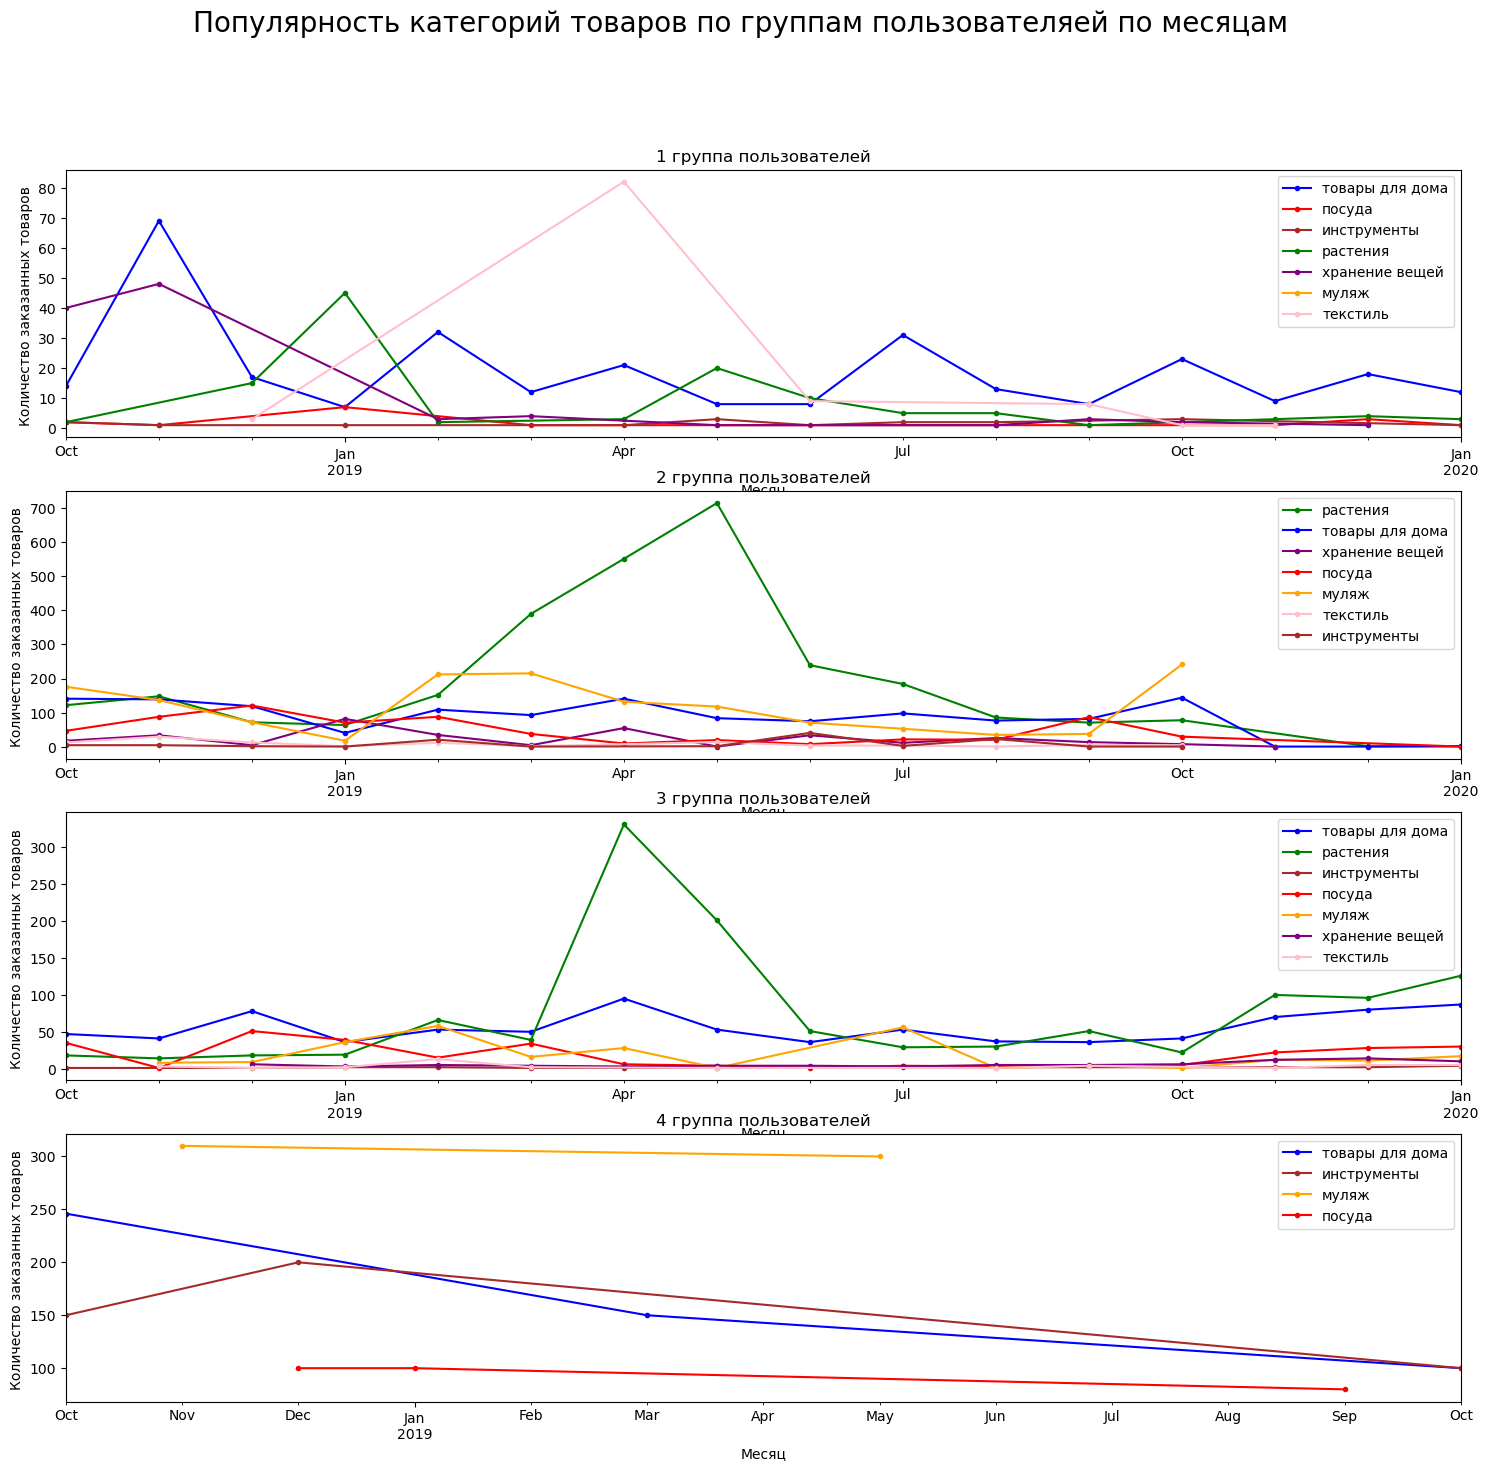

In [450]:
#plt.figure(figsize=[15, 18])
fig, ax = plt.subplots(4,1,figsize=(18,16))
colours = {'растения':'green', 'товары для дома':'blue', 'текстиль':'pink', 'посуда':'red', 'хранение вещей':'purple', 
          'инструменты':'brown', 'муляж':'orange'}
plt.suptitle('Популярность категорий товаров по группам пользователяей по месяцам', fontsize=20)
for t in range(4):
    plt.subplot(4,1,t+1)
    plt.title(f'{t+1} группа пользователей')
    cluster = merged_data[merged_data['cluster']==t]
    category_list = cluster['category'].unique()
    for i in category_list:
        lines = (cluster[cluster['category']==i].groupby('month_year')['quantity'].sum().
                plot(x='month_year',y='quantity',kind='line',style='.-', color=[colours[i] ], label=i))

    plt.ylabel('Количество заказанных товаров ')
    plt.xlabel('Месяц')
    plt.legend(loc='best')
plt.show();


Из полученных графиков мы видим, что:
- постоянные покупатели из первой группы предпочитают заказывать растения и товары для дома, при этом растения массово покупают в апреле-мае; 
- "оптовики" из второй группы заказывают недорогие товары только из четырех категорий, причем посуду заказывают меньше всего, предпочитая товары для дома, инструменты и муляжи;  
- покупатели из третьей группы, предпочитающие более дорогие товары, отдают предпочтение товарам для дома, текстилю (резкий всплеск в апреле), растениям (январь и май);
- разовые покупатели из четвертой группы заказывают в равной степени все категории, только с марта по июнь больше заказывают растения. Однако, мы видим, что с ноября 2019 года заказы резко упали по всем категориям.

Найдем теперь для каждой группы покупателей какая группа товаров заказывалась чаще всего.

In [281]:
grouped = merged_data.groupby(['cluster','month_year','category']).size().reset_index()
grouped.columns = ['cluster', 'month_year','category','counts']
grouped.head(21)

,cluster,month_year,category,counts
0,0,2018-10,инструменты,2
1,0,2018-10,посуда,2
2,0,2018-10,растения,2
3,0,2018-10,товары для дома,14
4,0,2018-10,хранение вещей,2
5,0,2018-11,инструменты,1
6,0,2018-11,посуда,1
7,0,2018-11,товары для дома,25
8,0,2018-11,хранение вещей,4
9,0,2018-12,растения,1


In [282]:
grouped_1 = grouped.loc[grouped.groupby(['cluster', 'month_year'])['counts'].idxmax()]
grouped_1[grouped_1['cluster']==3].head(10)

,cluster,month_year,category,counts
260,3,2018-10,товары для дома,2
261,3,2018-11,муляж,2
262,3,2018-12,инструменты,1
264,3,2019-01,посуда,1
265,3,2019-03,товары для дома,1
266,3,2019-05,муляж,1
267,3,2019-09,посуда,1
268,3,2019-10,инструменты,1


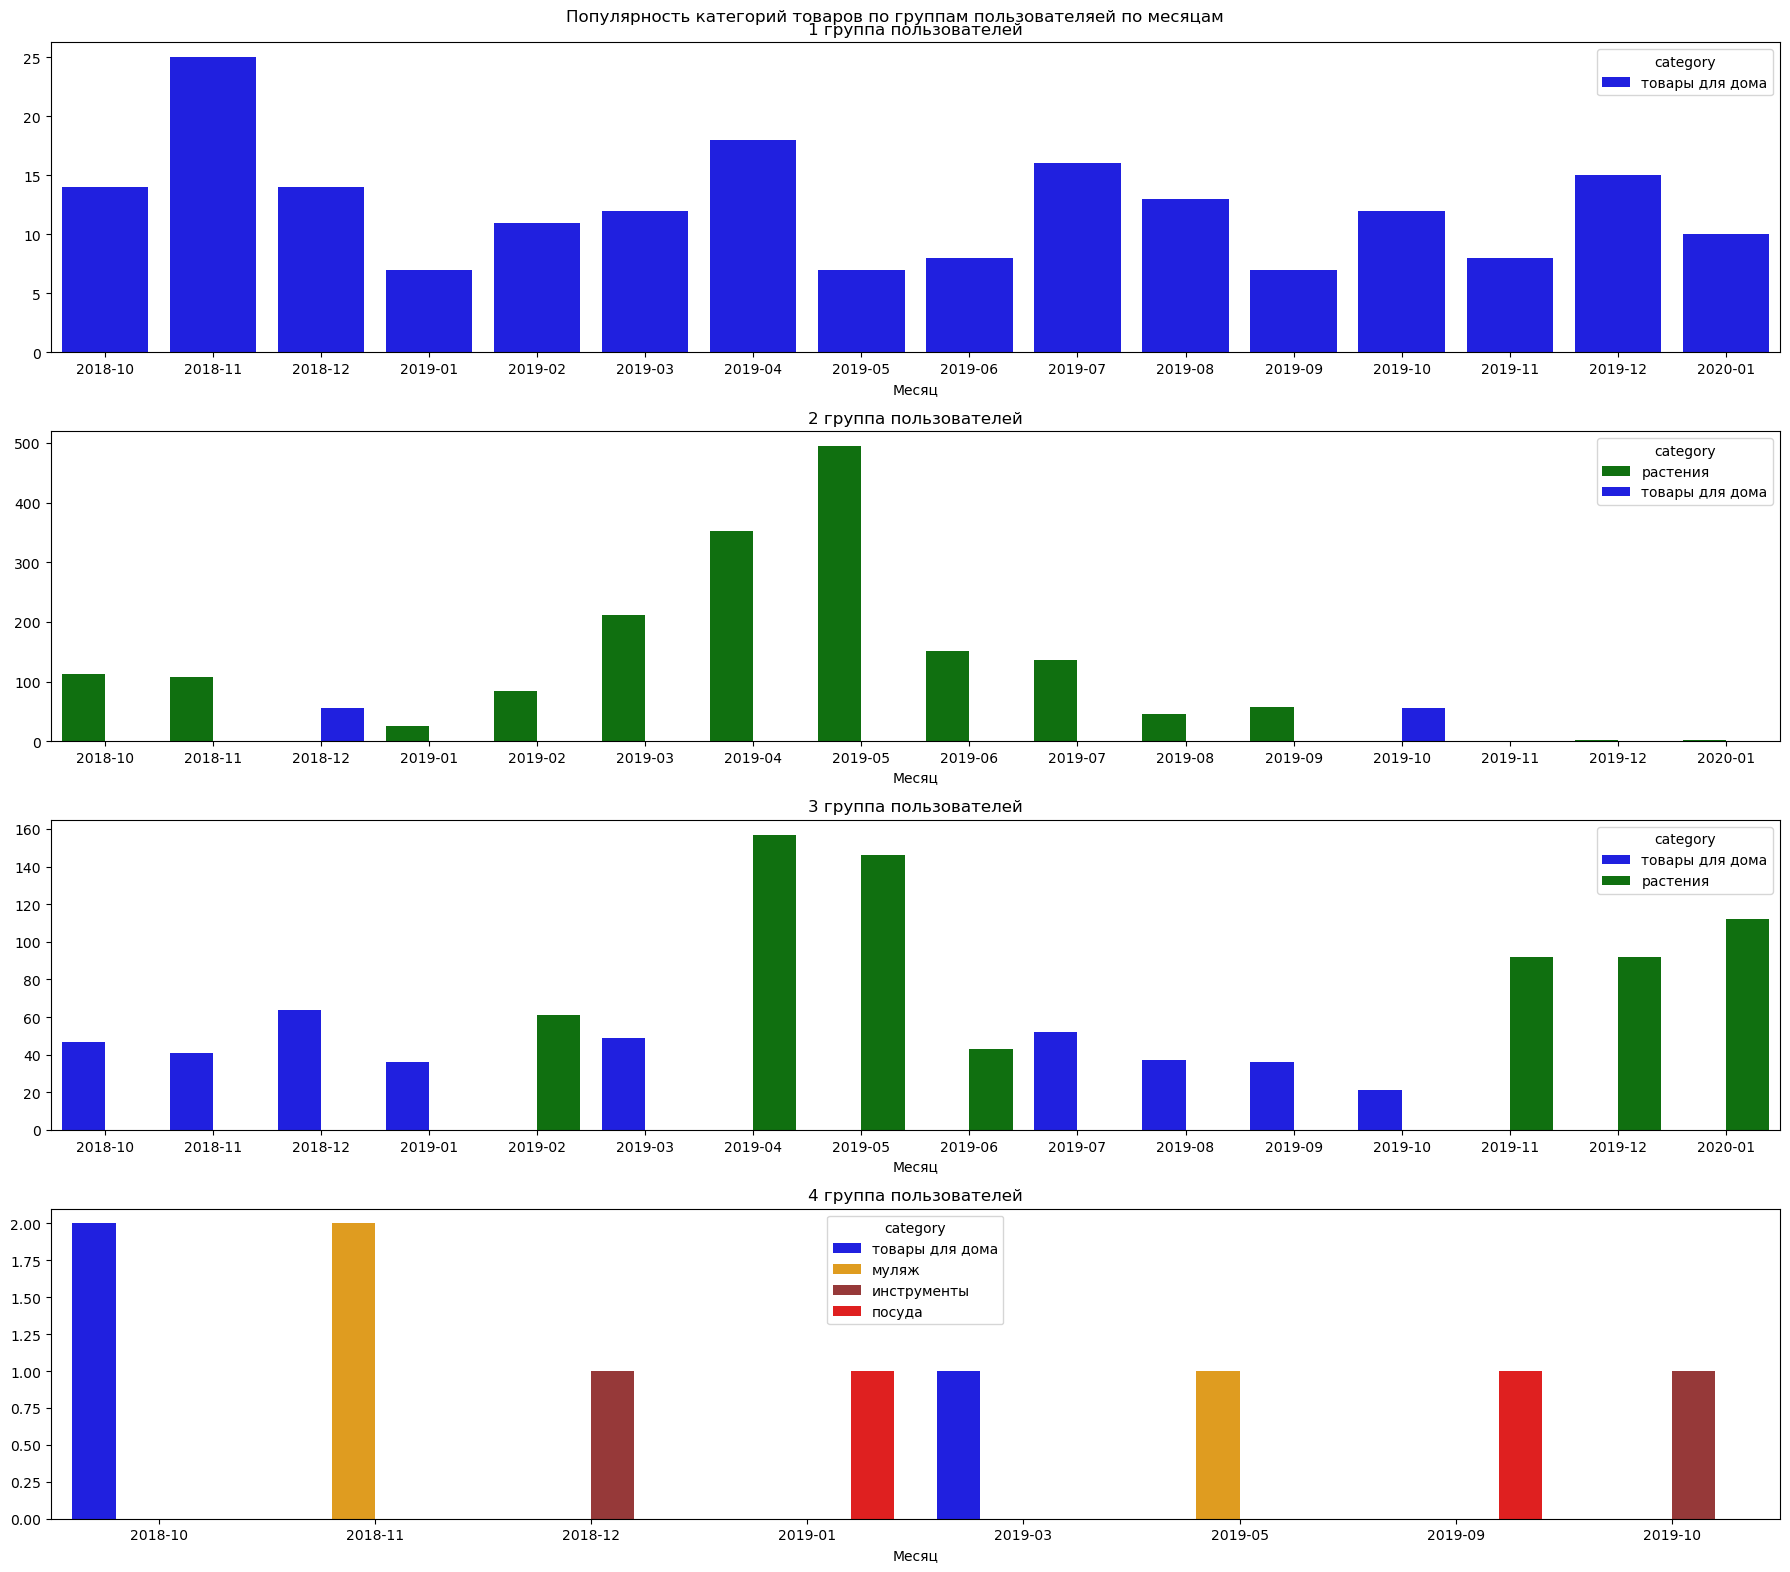

In [283]:
fig, ax = plt.subplots(4,1,figsize=(18,16))
colours = {'растения':'green', 'товары для дома':'blue', 'текстиль':'pink', 'посуда':'red', 'хранение вещей':'purple', 
          'инструменты':'brown', 'муляж':'orange'}
plt.suptitle('Популярность категорий товаров по группам пользователяей по месяцам')
for i in range(4):
    plt.subplot(4,1,i+1)
    plt.title(f'{i+1} группа пользователей')
    sns.barplot( x= 'month_year',y='counts', hue='category', data=grouped_1[grouped_1['cluster']==i], palette=colours)
    plt.xlabel('Месяц')
    plt.ylabel('')

plt.tight_layout()
plt.show();

Как видим, растения пользуются популярностью у первой и четвертой групп пользователей, однако первая группа покупает товары этой категории наиболее активно с в апреле-мае (скорее всего, покупаются семена и рассада), а также в ноябре-январе.

Четвертая группа часто заказывают растения в марте-июле.

У второй группы нет явных предпочтений, одинаково часто заказывают товары для дома, муляжи, посуду и инструменты .
    
Третья группа покупателей часто заказывают товары для дома в течение всего года.

### Определение наиболее часто покупаемых товаров для каждого сегмента

Найдем какие категории товаров чаще всего покупали наши пользователи с учетом разделения на группы.

Сначала для каждой группы пользователей и каждой категории товаров посчитаем сколько раз их заказывали.

In [288]:
cluster_products = merged_data.groupby(['cluster', 'category']).size().reset_index()
cluster_products.columns=['cluster', 'category','counts']
cluster_products.head()

,cluster,category,counts
0,0,инструменты,16
1,0,муляж,1
2,0,посуда,11
3,0,растения,28
4,0,текстиль,12


Теперь найдем для каждой группы категорию с наибольшим числом заказов

In [290]:
cluster_products.loc[cluster_products.groupby(['cluster'])['counts'].idxmax()]

,cluster,category,counts
5,0,товары для дома,197
10,1,растения,1889
17,2,растения,904
24,3,товары для дома,4


Поличили, что первая и четвертая группа чаще всего покупали растения, а вторая и третья - товары для дома.

### Определение наиболее прибыльных категорий товаров для каждого сегмента

Частота заказов не всегда дает нам наибольшую прибыль, посмотрим, какие категории товаров приносят магазину наибольшую прибыль с учетом разбиения на группы покупателей.

In [294]:
cluster_purchase = merged_data.groupby(['cluster', 'category'])['purchase'].agg('sum').reset_index()
cluster_purchase.head(10)

,cluster,category,purchase
0,0,инструменты,56684.0
1,0,муляж,127.0
2,0,посуда,15173.0
3,0,растения,79527.0
4,0,текстиль,86036.0
5,0,товары для дома,794968.5
6,0,хранение вещей,58998.0
7,1,инструменты,23039.0
8,1,муляж,70745.0
9,1,посуда,131938.0


In [295]:
cluster_purchase.loc[cluster_purchase.groupby(['cluster'])['purchase'].idxmax()]

,cluster,category,purchase
5,0,товары для дома,794968.50
12,1,товары для дома,503175.50
19,2,товары для дома,765635.75
22,3,муляж,32230.00


Здесь мы видим, что не смотря на популярность растений у покупателей первой и четвертой группы наибольшую прибыль нам приносят товары для дома. Это легко объяснимо, так как растения - сезонный товар, а товары для дома - нет, их покупают постоянно в течение  года.

Вторая  группа покупателей наибольшую сумму потратила на муляжи.

Третья группа покупателей покупают в основном только товары для дома, что и дает наибольшую прибыль.

## Проверка статистических гипотез

Мы разбили пользователей на четыре группы, проверим правильно ли у нас прошло разбиение.

Сформулируем гипотезы о правильности полученного разбиения:

- Проверим, что есть различия по среднему чеку среди групп
- Проверим, что есть различия по количеству покупок среди групп

Сначала мы определим, какой тест будем использовать для проверки гипотез.

Мы можем использовать либо параметрический t-тест, либо непараметрический критерий Манна-Уитни.

Для использования t-теста у нас должны выполняться несколько условий:
 1. генеральные совокупности не зависят друг от друга
 
 В нашем случае разбиение на классы пользователей независимо.
 
 2. Выборочные средние нормально распределены.
 
 Необходимо проверить распределения на нормальность.
 
 3. Дисперсии рассматриваемых генеральных совокупностей равны.
 
 Это условие можно обойти (так как у нас выборки разного размера) , поэтому можно указать параметр equal_var=False.

Проверим нормально ли распределены у нас средние значения.

Для проверки гипотезы о различии среднего чека нужно проверить на нормальное распределение средние чеки в классах. Будем использовать тест Шапиро-Уилка.

In [303]:
# Тест Шапиро-Уилка
# Определение функции для теста Шапиро-Уилка
def shapiro_test(data, alpha=0.05):
    stat, p = shapiro(data)
    if p > alpha:
        print('Данные выглядят как нормальные (гауссовские)')
    else:
        print('Данные не выглядят как нормальные (гауссовские)')

In [304]:
shapiro_test(cluster_0['bill_avg'])
shapiro_test(cluster_1['bill_avg'])
shapiro_test(cluster_2['bill_avg'])
shapiro_test(cluster_3['bill_avg'])


Данные не выглядят как нормальные (гауссовские)
Данные не выглядят как нормальные (гауссовские)
Данные не выглядят как нормальные (гауссовские)
Данные не выглядят как нормальные (гауссовские)


In [305]:
shapiro_test(cluster_0['order_count'])
shapiro_test(cluster_1['order_count'])
shapiro_test(cluster_2['order_count'])
shapiro_test(cluster_3['order_count'])


Данные не выглядят как нормальные (гауссовские)
Данные выглядят как нормальные (гауссовские)
Данные не выглядят как нормальные (гауссовские)
Данные выглядят как нормальные (гауссовские)


C:\ProgramData\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:1879: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


Таким образом, наши данные не прошли проверку на нормальное распределение, следовательно, применять t-тест нельзя.

Для проверки будем использовать критерий Манна-Уитни.

Так как у нас 4 группы и нам нужно попарно проверить их на равенство, то нам нужно внести поправку на множественную проверку гипотез.

Зададим уровень значимости `alpha = 0.05`

Будем использовать поправку Бонферрони.

Так как у нас четыре группы, то нам придется провести 6 тестов для каждой из гипотез.

Тогда уровень значимости с поправкой Бонферрони будет равен `alpha_corr = alpha / 6`.

In [309]:
alpha = 0.05
alpha_corr = alpha / 6

### Проверка гипотезы о различии среднего чека

Сформулируем гипотезы:

H0 - средний чек между классами не различается 

H1 - средний чек между классами отличается

In [312]:
print(f'Средний чек пользователей первой группы :{round(np.mean(cluster_0["bill_avg"]),2)}')
print(f'Средняя чек пользователей второй группы:{round(np.mean(cluster_1["bill_avg"]),2)}')
print(f'Средняя чек пользователей третьей группы:{round(np.mean(cluster_2["bill_avg"]),2)}')
print(f'Средняя чек пользователей четвертой группы:{round(np.mean(cluster_3["bill_avg"]),2)}')

Средний чек пользователей первой группы :4293.92
Средняя чек пользователей второй группы:859.15
Средняя чек пользователей третьей группы:680.56
Средняя чек пользователей четвертой группы:5760.67


Проверим нашу гипотезу

In [314]:
# Список кластеров и их имена
clusters = [cluster_0['bill_avg'], cluster_1['bill_avg'], cluster_2['bill_avg'], cluster_3['bill_avg']]
cluster_names = ['cluster_0', 'cluster_1', 'cluster_2', 'cluster_3']

# Попарное сравнение Манна-Уитни с поправкой Бонферрони
for (i, cluster_a), (j, cluster_b) in combinations(enumerate(clusters), 2):
    cluster_name_a = cluster_names[i]
    cluster_name_b = cluster_names[j]
    
    # Тест Манна-Уитни
    results = mannwhitneyu(cluster_a, cluster_b, True, alternative='two-sided')
    
    # Вывод результатов
    if results.pvalue < alpha_corr:
        print(f"{cluster_name_a} и {cluster_name_b}: Отвергаем нулевую гипотезу - разница статистически значима")
    else:
        print(
        f"{cluster_name_a} и {cluster_name_b}: Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя"
        ) 
    

cluster_0 и cluster_1: Отвергаем нулевую гипотезу - разница статистически значима
cluster_0 и cluster_2: Отвергаем нулевую гипотезу - разница статистически значима
cluster_0 и cluster_3: Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя
cluster_1 и cluster_2: Отвергаем нулевую гипотезу - разница статистически значима
cluster_1 и cluster_3: Отвергаем нулевую гипотезу - разница статистически значима
cluster_2 и cluster_3: Отвергаем нулевую гипотезу - разница статистически значима


Таким образом, мы отвергаем гипотезу о том, что средний чек по группам не различается.

Следовательно, мы можем предположить, что разбиение на группы по среднему чеку правильное.

### Проверка гипотезы о различии количества заказанных товаров

Теперь проверим правильность разбиения на группы по количеству заказанных товаров.

Сформулируем гипотезы:
    
H0 - количество товаров между классами не различается

H1 - количество товаров между классами отличается

In [319]:
print(f'Среднее количество заказанных товаров пользователями первой группы :{round(np.mean(cluster_0["products_avg"]),3)}')
print(f'Среднее количество заказанных товаров пользователями второй группы:{round(np.mean(cluster_1["products_avg"]),3)}')
print(f'Среднее количество заказанных товаров пользователями третьей группы :{round(np.mean(cluster_2["products_avg"]),3)}')
print(f'Среднее количество заказанных товаров пользователями четвертой группы:{round(np.mean(cluster_3["products_avg"]),3)}')

Среднее количество заказанных товаров пользователями первой группы :2.696
Среднее количество заказанных товаров пользователями второй группы:4.961
Среднее количество заказанных товаров пользователями третьей группы :1.58
Среднее количество заказанных товаров пользователями четвертой группы:153.0


In [320]:
# Список кластеров и их имена
clusters = [cluster_0['products_avg'], cluster_1['products_avg'], cluster_2['products_avg'], cluster_3['products_avg']]
cluster_names = ['cluster_0', 'cluster_1', 'cluster_2', 'cluster_3']

# Попарное сравнение Манна-Уитни с поправкой Бонферрони
for (i, cluster_a), (j, cluster_b) in combinations(enumerate(clusters), 2):
    cluster_name_a = cluster_names[i]
    cluster_name_b = cluster_names[j]
    
    # Тест Манна-Уитни
    results = mannwhitneyu(cluster_a, cluster_b, True, alternative='two-sided')
    
    # Вывод результатов
    if results.pvalue < alpha_corr:
        print(f"{cluster_name_a} и {cluster_name_b}: Отвергаем нулевую гипотезу - разница статистически значима")
    else:
        print(
        f"{cluster_name_a} и {cluster_name_b}: Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя"
        ) 

cluster_0 и cluster_1: Отвергаем нулевую гипотезу - разница статистически значима
cluster_0 и cluster_2: Отвергаем нулевую гипотезу - разница статистически значима
cluster_0 и cluster_3: Отвергаем нулевую гипотезу - разница статистически значима
cluster_1 и cluster_2: Отвергаем нулевую гипотезу - разница статистически значима
cluster_1 и cluster_3: Отвергаем нулевую гипотезу - разница статистически значима
cluster_2 и cluster_3: Отвергаем нулевую гипотезу - разница статистически значима


Таким образом, мы отвергаем гипотезу о том, что среднее количество заказов по группам не различается.

Следовательно, мы можем предположить, что разбиение на группы по среднему количеству покупок верное.

## Рекомендации

Сформируем рекомендации по каждому классу, с учетом того какие категории товаров в каждом классе пользуются наибольшим спросом, можно ли предложить более дорогие аналоги на основании среднего чека группы, есть ли сезонные товары, которые пользуются спросом в каждой группе, а также как часто можно ожидать покупки.

### Первая группа

**Первая группа пользователей** - это группа пользователей интернет-магазина, которые делают делают как минимум два заказа, то есть мы можем их причислить к постоянным покупателям, заказывая в среднем один-два товара за раз, при этом они выбирают товары, стоимостью  от 400 до 600 рублей, при этом средний заказ у них выходит на 500-700 рублей;

Наша задача будет состоять в том, чтобы увеличить их средний чек. 

Они покупают в основном растения и товары для дома, однако, растения - сезонный товар, пользующийся спросом у этих покупателей в в апреле-мае, а также в ноябре-январе. Поэтому для рассылки рекламы этих товаров предлагается период март-май и сентябрь-октябрь.

Товары для дома эти пользователи покупают в течение всего года, поэтому возможна рассылка рекламы товаров этой категории в течение всего года.

Большинство пользователи покупают товары  стоимостью от 400 до 600 рублей. Покупатели заказывают одновременно 1-2 товара, поэтому возможно делать рассылку немного чаще.

### Вторая группа

**Вторая группа пользователей**  - самая малочисленная группа, их можно назвать "оптовиками", так как они заказывают в среднем по 100-150 товаров. Пользователи из этой группы предпочитают самые дешевые товары, средней стоимостью около 30-40 рублей, при этом они делают в основном только один заказ, и средний чек у них выходит на 4000-5000 рублей.

Задача по работе с этой группой покупателей -  повторные заказы.

Эти покупатели заказывают в основном только муляжи, товары для дома, инструменты и посуду. При этом они делают разовые большие заказы дешевых товаров. 

Наибольшую прибыль принесли муляжи, поэтому приоритетом на рекламу можно указать именно их, а также товары для дома и инструменты . 

Заказывают много *дешевых* товаров, поэтому приоритет именно на дешевые товары.

Так как покупают в основном один товар, то в рекламной рассылке можно указывать дополнительные товары, которые пойдут комплектом с интересующим. Тем самым мы сподвигнем пользователей заказать больше товаров, а следовательно вырастет и средний чек. 

### Третья группа

**Третья группа пользователей** - покупатели из третьей группы заказывают дорогие товаров, стоимостью около 3000 рублей,  делают один - два заказа.

Наша задача при работе с этой группой пользователей - не потерять данных клиентов, так как они приносят большой средний чек, но делают в основном только один заказ.

В основном они заказывают товары для дома, при этом видно цикличность покупок - раз в месяц-два локальный пик по количеству заказываемых товаров (в ноябре-декабре покупка подарков).

Они предпочитают качественные дорогие вещи, поэтому при рассылке стоит ориентироваться на эксклюзивные предложения товаров, текстиля.

### Четвертая группа

*Четвертая группа* - самая многочисленная группа, они делают только один заказ, при этом стоимость товаров колеблется от 14 до 2000 рублей, в основном около 200-400 рублей. Заказывают в среднем 2-5 товаров.

Наша задача при работе с этой групполь покупателей - повторные заказы.

Пик их покупательской активности - с марта по май, в основном они покупают растения. Однако, большую прибыль от них приносят товары для дома.
 
 При рассылке рекламы возможно показывать наличие каких-либо эксклюзивных семян и растений, чтобы вызвать интерес у покупателей. Также можно одновременно плказывать сопутствующие товары, необходимые при проращивании семян и для ухода за рассадой.
 
 Также стоит посмотреть почему с ноября 2019 года покупки практически прекратились.

## Вывод

Нам для анализа были предоставлены данные о транзакциях интернет-магазина товаров для дома и быта "Пока все тут". Всего у нас было 7474 записи о транзакциях.

 Данные имели проблемы с типом даты заказы, в ходе работы было установлено, что данные имеют много скрытых дубликатов, что, возможно, связано, со способом выгрузки данных. Пропусков в данных нет, но есть аномальные значения в количестве заказанных товаров. Аномальные значения мы удалили. После обработки данных у нас осталось 5584 записи.

Мы добавили столбцы с месяцем заказа и стоимостью заказанных товаров.

В наших записях есть данные о 2342 различных товарах, купленных в магазине. Мы разделили их на семь категорий: растения, товары для дома, текстиль, посуда, инструмент, хранение вещей и муляжи.

**Товары** распределилиcь по категориям следующим образом:

* муляжи 

*в эту категорию войдут искусственные цветы, муляжи овощей и фруктов, композиции из искусственных цветов*

* растения

*сюда войдут комнатные растения, рассада и семена* 

* посуда

*все для приготовления и употребления пищи*

* товары для дома

*все, что может потребоваться дома*

* текстиль

*от теплого одеяла до уютного халата и красивых полотенец и скатерти на кухню*

* хранение вещей

*всевозможные кофры, ящики, чехлы, вешалки, короба и т.д.*

* инструменты

*сверла, стяжки, пружины, напильники, шнуры и шпагаты и многое другое*

Чаще всего покупатели брали растения (больше всего заказывали живые цветы черенками, комнатные растения) и товары для дома. При этом товары для дома наиболее активно заказывали в октябре, декабре и марте, растения с марта по май. В декабре активно покупали все, кроме муляжей, текстиля, товаров для хранения вещей и растений, что объяснимо покупкой подарков к праздникам. Заказы были в основном до 5000 рублей, люди брали товары стоимостью до 2000 рублей и совершали не более трех заказов.

Полученные данные, а именно средний чек, средняя стоимость товара, количество заказов, среднее количество товаров в одном заказе по каждому клиенту мы используем для того, чтобы разбить пользователей на группы. Для кластеризации пользователей мы воспользуемся методами *машинного обучения*.

Проверили, что полученные параметры линейно независимы друг от друга.
Для кластеризации мы использовали метод **K-means**.


**Мы получили четыре группы покупателей:**

- **первая группа**

Это группа пользователей интернет-магазина, которые делают делают как минимум два заказа, то есть мы можем их причислить к постоянным покупателям, заказывая в среднем один-два товара за раз, при этом они выбирают товары, стоимостью  от 400 до 600 рублей, при этом средний заказ у них выходит на 500-700 рублей;
   
- **вторая группа**

Самая малочисленная группа, их можно назвать "оптовиками", так как они заказывают в среднем по 100-150 товаров. Пользователи из этой группы предпочитают самые дешевые товары, средней стоимостью около 30-40 рублей, при этом они делают в основном только один заказ, и средний чек у них выходит на 4000-5000 рублей;
   
- **третья группа**

Покупатели из третьей группы заказывают дорогие товаров, стоимостью около 3000 рублей,  делают один - два заказа;
   
- **четвертая группа**

Самая многочисленная группа, они делают только один заказ, при этом стоимость товаров колеблется от 14 до 2000 рублей, в основном около 200-400 рублей. Заказывают в среднем 2-5 товаров.

Мы изучили как *пользователи разных групп покупали товары*:

- постоянные покупатели из первой группы предпочитают заказывать растения и товары для дома, при этом растения массово покупают в апреле-мае; 

- "оптовики" из второй группы заказывают недорогие товары только из четырех категорий, причем посуду заказывают меньше всего, предпочитая товары для дома, инструменты и муляжи;  

- покупатели из третьей группы, предпочитающие более дорогие товары, отдают предпочтение товарам для дома, текстилю (резкий всплеск в апреле), растениям (январь и май);

- разовые покупатели из четвертой группы заказывают в равной степени все категории, только с марта по июнь больше заказывают растения. Однако, мы видим, что с ноября 2019 года заказы резко упали по всем категориям.

Не смотря на популярность растений у покупателей первой и четвертой группы **наибольшую прибыль** нам приносят товары для дома. Это легко объяснимо, так как растения - сезонный товар, а товары для дома - нет, их покупают постоянно в течение  года.

Вторая  группа покупателей наибольшую сумму потратила на муляжи.

Третья группа покупателей покупают в основном только товары для дома, что и дает наибольшую прибыль.

Мы также проверили, что разбиение на группы у нас правильное.

И сформировали **рекомендации по каждой группе пользователей**.

При  работе с **первой группой** клиентов наша задача будет состоять в том, чтобы увеличить их средний чек. 

Они покупают в основном растения и товары для дома, однако, растения - сезонный товар, пользующийся спросом у этих покупателей в в апреле-мае, а также в ноябре-январе. Поэтому для рассылки рекламы этих товаров предлагается период март-май и сентябрь-октябрь.

Товары для дома эти пользователи покупают в течение всего года, поэтому возможна рассылка рекламы товаров этой категории в течение всего года.

Большинство пользователи покупают товары  стоимостью от 400 до 600 рублей. Покупатели заказывают одновременно 1-2 товара, поэтому возможно делать рассылку немного чаще.

**Вторую группу** пользователей можно отнести к  разовым "оптовикам" (их меньше всего).

Задача по работе с этой группой покупателей - повторные заказы.

Эти покупатели заказывают в основном только муляжи, товары для дома, инструменты и посуду. При этом они делают разовые большие заказы дешевых товаров.

Наибольшую прибыль принесли муляжи, поэтому приоритетом на рекламу можно указать именно их, а также товары для дома и инструменты .

Заказывают много дешевых товаров, поэтому приоритет именно на дешевые товары.

Так как покупают в основном один товар, то в рекламной рассылке можно указывать дополнительные товары, которые пойдут комплектом с интересующим. Тем самым мы сподвигнем пользователей заказать больше товаров, а следовательно вырастет и средний чек.

**Третья группа пользователей** - любители дорогих товаров.

Наша задача при работе с этой группой пользователей - не потерять данных клиентов, так как они приносят большой средний чек, но делают в основном только один заказ.

В основном они заказывают товары для дома, при этом видно цикличность покупок - раз в месяц-два локальный пик по количеству заказываемых товаров (в ноябре-декабре покупка подарков).

Они предпочитают качественные дорогие вещи, поэтому при рассылке стоит ориентироваться на эксклюзивные предложения товаров, текстиля.

**Четвертая группа** - самая многочисленная группа, они делают только один заказ, при этом стоимость товаров колеблется от 14 до 2000 рублей, в основном около 200-400 рублей. Заказывают в среднем 2-5 товаров.

Наша задача при работе с этой групполь покупателей - повторные заказы.

Пик их покупательской активности - с марта по май, в основном они покупают растения. Однако, большую прибыль от них приносят товары для дома.
 
При рассылке рекламы возможно показывать наличие каких-либо эксклюзивных семян и растений, чтобы вызвать интерес у покупателей. Также можно одновременно плказывать сопутствующие товары, необходимые при проращивании семян и для ухода за рассадой.
 
 Также стоит посмотреть почему с ноября 2019 года покупки практически прекратились.